In [1]:
import sys 
import os
import math
import time 
import random
import tracemalloc 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import SVG, display, Markdown 

### Lightweight DBMS with B+ Tree Indexing - Report

**Group:** Olympia Track

**Team Members:** Bhanu Repalle, Thumma Ushasree, Saloni Shinde

**Assignment:** Module 4

## 1. Introduction

### Problem Addressed
Efficiently storing and retrieving large amounts of data is a fundamental challenge in computer science. Simple data structures like lists or arrays become inefficient for searching, inserting, or deleting specific records as the dataset grows (often requiring O(n) time complexity). Range queries (finding all records within a certain key range) are also slow in unsorted structures. Database systems, especially those dealing with disk-based storage (though the principle applies to memory), need specialized structures to minimize access time and perform operations quickly.

### Proposed Solution: B+ Tree DBMS
This project implements a lightweight Database Management System (DBMS) in Python. The core of this system relies on the **B+ Tree**, a self-balancing tree data structure optimized for block-based storage and efficient data management.

**Key features of the B+ Tree making it suitable:**
*   **Balanced Structure:** Ensures that all leaf nodes are at the same depth, guaranteeing logarithmic time complexity (O(log n)) for search, insertion, and deletion operations, avoiding worst-case scenarios.
*   **High Fanout:** Internal nodes can store many keys and child pointers, matching well with disk block sizes (reducing I/O in disk-based systems) and creating a wide, shallow tree.
*   **Efficient Range Queries:** All data pointers (or data itself) reside *only* in the leaf nodes, which are linked together sequentially (like a linked list). This allows for very fast retrieval of records within a key range by finding the start leaf and following the links.

This report details the implementation of the B+ Tree and its associated operations, followed by a performance analysis comparing it to a brute-force approach, and concludes with examples of its visualization.

## 2. Implementation

This section describes the core components and algorithms used in the B+ Tree implementation (`bplustree.py`).

We will first set up imports and a helper function for visualization used in the subsequent demonstration cells.

### B+ Tree Node (`BPlusTreeNode`)

The fundamental building block is the `BPlusTreeNode`. A single class is used for both internal and leaf nodes, differentiated by an `is_leaf` boolean flag.

*   **`order`**: An integer defining the maximum capacity of the node (specifically, max children for internal nodes, related to max keys).
*   **`is_leaf`**: Boolean flag (`True` for leaf nodes, `False` for internal nodes).
*   **`keys`**: A sorted list of keys stored in the node. Max keys = `order - 1`.
*   **`values`**: A list whose content depends on `is_leaf`:
    *   If `is_leaf=True`: Stores the actual data values associated with the keys. `len(values)` == `len(keys)`.
    *   If `is_leaf=False`: Stores references (pointers) to child `BPlusTreeNode` objects. `len(values)` == `len(keys) + 1`.
*   **`parent`**: A reference to the parent node (None for the root). Essential for splitting and merging operations.
*   **`next_leaf`**: A reference to the next leaf node in sequence (None for internal nodes or the last leaf). Used for efficient range queries.

Helper methods like `is_full()` and `is_underflow()` check if the node has reached its maximum or fallen below its minimum key capacity, respectively.

In [2]:
try:
    import graphviz
    from database.table import Table 
    from database.db_manager import DatabaseManager
    from database.performance import PerformanceAnalyzer
    from database.bplustree import BPlusTree, BPlusTreeNode
except ModuleNotFoundError as e:
    print(f"Error importing database modules: {e}")
    raise
except ImportError:
     print("Graphviz library not found (pip install graphviz). Visualization will be skipped.")
     graphviz = None

# --- Helper function for visualization ---
def visualize_and_display(tree, title="B+ Tree State"):
    """Generates and displays the tree visualization."""
    display(Markdown(f"#### {title}")) # Smaller heading for steps
    if not graphviz:
        print("Skipping visualization (graphviz not installed).")
        return

    dot = tree.visualize_tree()
    if dot:
        try:
            svg_data = dot.pipe(format='svg').decode('utf-8')
            display(SVG(svg_data)) # Display SVG in output
        except graphviz.backend.execute.ExecutableNotFound:
             print("\nERROR: Graphviz executable not found in PATH.")
        except Exception as e:
             print(f"\nAn error occurred during visualization rendering: {e}")
    else:
        print("Visualization object could not be created.")

print("Setup complete.")

Setup complete.


### 1. Insertion Operation Demonstration (`insert`, `_split_node`, `_insert_in_parent`)

This sequence demonstrates the insertion process and how the tree dynamically restructures itself through splits when nodes become full. We use `order=4` (max 3 keys/node, min 1 key/node).

1.  **Initial Inserts:** Keys `[10, 20, 5]` are inserted into the initial empty root leaf node. The node becomes `[5, 10, 20]` which is now full (max capacity reached).
2.  **Leaf Split & New Root:** Inserting `15` causes the leaf `[5, 10, 20]` to overflow (conceptual `[5, 10, 15, 20]`).
    *   `_split_node` divides it into `[5, 10]` and `[15, 20]`.
    *   The first key of the new right sibling (`15`) is copied up.
    *   Since the split node was the root, `_insert_in_parent` creates a new internal root `[15]` pointing to the two leaves. Tree height becomes 2.
3.  **Simple Insert:** Inserting `25` finds the correct leaf (`[15, 20]`) and adds the key, making it `[15, 20, 25]`. This leaf is now full.
4.  **Leaf Split & Parent Update:** Inserting `40` finds the leaf `[15, 20, 25]`. It overflows (`[15, 20, 25, 40]`).
    *   `_split_node` divides it into `[15, 20]` and `[25, 40]`.
    *   The first key of the new right sibling (`25`) is copied up.
    *   `_insert_in_parent` adds key `25` and the pointer to the new leaf into the existing root `[15]`. The root becomes `[15, 25]`. The root is now full but does not split yet.

--- Scenario 1: Insertions and Splits ---
(Using order=4, min_keys=1)


####  Initial Empty Tree

#### 1.1: After inserting [10, 20, 5] (Leaf Full)

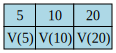

#### 1.2: After inserting 15 (Triggers Leaf Split -> New Root)...

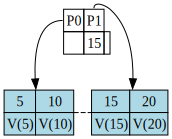

#### 1.3: After inserting [25] (Right Leaf Full)

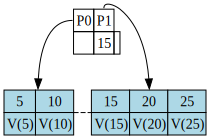

#### 1.4: After inserting 40 (Parent Split)

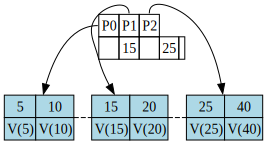

In [3]:
# --- Initialize Tree for Scenario 1 ---
print("--- Scenario 1: Insertions and Splits ---")
print(f"(Using order=4, min_keys=1)")
tree1 = BPlusTree(order=4)
visualize_and_display(tree1, " Initial Empty Tree")

# 1a. Insert first few keys (fill leaf)
keys1 = [10, 20, 5]
for k in keys1: tree1.insert(k, f"Val_{k}")
visualize_and_display(tree1, "1.1: After inserting [10, 20, 5] (Leaf Full)")

# 1b. Trigger first leaf split & new root
key_split1 = 15
tree1.insert(key_split1, f"Val_{key_split1}")
visualize_and_display(tree1, f"1.2: After inserting {key_split1} (Triggers Leaf Split -> New Root)...")

# 1c. Insert to cause second leaf split (updating parent)
keys2 = [25] 
for k in keys2: tree1.insert(k, f"Val_{k}")
visualize_and_display(tree1, f"1.3: After inserting {keys2} (Right Leaf Full)")

# 1d. Insert to cause internal split
keys3 = 40 
tree1.insert(keys3, f"Val_{keys3}")
visualize_and_display(tree1, f"1.4: After inserting {keys3} (Parent Split)")

### 2. Deletion Operation Demonstration (`delete`, `_handle_underflow`, `_borrow_...`)

This sequence demonstrates deletion scenarios, including simple deletion and rebalancing using borrowing. We use `order=4` (min 1 key/node).

1.  **Initial State:** We start by inserting keys `[10, 20, 5, 15, 25]` to create a tree. The resulting state is: Root `[15]`, Leaves `[5, 10]`, `[15, 20, 25]`.
2.  **Simple Deletion:** Key `25` is deleted from leaf `[15, 20, 25]`.
    *   The leaf becomes `[15, 20]`.
    *   It still contains 2 keys (>= minimum 1), so no underflow occurs and no rebalancing is needed.
3.  **Prepare for Borrow:** Key `10` is deleted from leaf `[5, 10]`.
    *   The leaf becomes `[5]`.
    *   It contains 1 key (>= minimum 1), so no underflow occurs yet. This step leaves the node at its minimum size, setting up the next deletion.
4.  **Deletion Causing Borrow from Right:** Key `5` is deleted from leaf `[5]`.
    *   The leaf becomes `[]`, causing underflow (0 keys < minimum 1). `_handle_underflow` is called.
    *   The implementation checks siblings. Left sibling: None. Right sibling: `[15, 20]`.
    *   The right sibling has 2 keys (> minimum 1), so it **can lend**.
    *   `_borrow_from_right` executes:
        *   The first key/value (`15`, `Val_15`) is moved from the right sibling `[15, 20]` to the underflowing node `[]`. The node becomes `[15]`.
        *   The right sibling becomes `[20]`.
        *   The separator key in the parent `[15]` (which is key `15` itself) is updated to become the *new* first key of the right sibling (`20`). The parent (root) becomes `[20]`.
    *   The tree is rebalanced.

--- Scenario 2: Simple Delete & Borrow Right ---

Inserting [10, 20, 5, 15, 25]...


#### 2.1: Initial State for Deletion

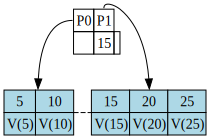

#### 2.2: After deleting 25 (Simple case)...

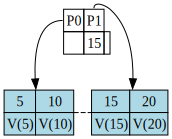

#### 2.3 Intermediate after deleting 10 (Before Borrow)

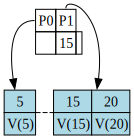

#### 2.4: After deleting 5 (Borrowed from Right and update parent)

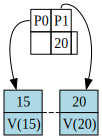

In [5]:
# --- Initialize Tree for Scenario 2 ---
print("--- Scenario 2: Simple Delete & Borrow Right ---")
tree2 = BPlusTree(order=4)
keys = [10, 20, 5, 15, 25] 
print(f"\nInserting {keys}...")
for k in keys: tree2.insert(k, f"Val_{k}")
visualize_and_display(tree2, "2.1: Initial State for Deletion")

# 2a. Simple Delete
key_del_simple = 25
deleted = tree2.delete(key_del_simple); 
visualize_and_display(tree2, f"2.2: After deleting {key_del_simple} (Simple case)...")

# 2b. Delete causing underflow and borrow Right
key_del_borrow = 10
deleted = tree2.delete(key_del_borrow)
visualize_and_display(tree2, f"2.3 Intermediate after deleting {key_del_borrow} (Before Borrow)")

key_del_borrow2 = 5
deleted = tree2.delete(key_del_borrow2)
visualize_and_display(tree2, f"2.4: After deleting {key_del_borrow2} (Borrowed from Right and update parent)")

### 3. Scenario: Borrow from Left Sibling (`delete`, `_handle_underflow`, `_borrow_from_right`)

This sequence demonstrates a case where deletion causes underflow, and the node borrows from its **right** sibling. We use `order=4` (min 1 key/node).

1.  **Initial State:** Insert keys `[10, 20, 5, 15]`. This creates Root `[15]`, Leaves `[5, 10]`, `[15, 20]`.
2.  **Delete `20`:** Key `20` is deleted from leaf `[15, 20]`.
    *   The leaf becomes `[15]`.
    *   It contains 1 key (>= minimum 1), so no underflow occurs.
3.  **Delete `15` (Causes Underflow & Borrow):** Key `15` is deleted from leaf `[15]`.
    *   The leaf becomes `[]`, causing underflow (0 keys < minimum 1). `_handle_underflow` is called.
    *   Parent is Root `[15]`. Node `[]` is child index 1.
    *   Checks Left Sibling `[5, 10]` (Index 0). Has 2 keys (> min 1). **Can borrow left.**
    *   Checks Right Sibling: None exists.
    *   The implementation prioritizes borrowing from the **left** if possible. `_borrow_from_left` executes:
        *   Parent separator key at index `1-1=0` is `15`. Key `15` moves down to node `[]` -> `[15]`.
        *   Last key `10` from left sibling `[5, 10]` moves up to replace parent key `15`. Parent becomes `[10]`.
        *   Left sibling becomes `[5]`.
    *   **Result:** Tree is rebalanced. Root `[10]`, Leaves `[5]`, `[15]`.

--- Scenario 3: Borrow Left ---

Inserting [10, 20, 5, 15]...


#### 3.1: Initial State for Deletion

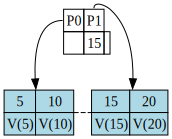

#### 3.3: After deleting 20

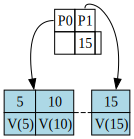

#### 3.3: After deleting 15 (Borrowed from Left and update parent)

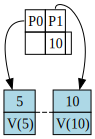

In [7]:
# --- Initialize Tree for Scenario 3 ---
print("--- Scenario 3: Borrow Left ---")
tree3 = BPlusTree(order=4)
keys = [10, 20, 5, 15] 
print(f"\nInserting {keys}...")
for k in keys: tree3.insert(k, f"Val_{k}")
visualize_and_display(tree3, "3.1: Initial State for Deletion")

# 3a. Delete causing underflow and borrow Left
key_del_borrow = 20
deleted = tree3.delete(key_del_borrow)
visualize_and_display(tree3, f"3.3: After deleting {key_del_borrow}")

key_del_borrow2 = 15
deleted = tree3.delete(key_del_borrow2)
visualize_and_display(tree3, f"3.3: After deleting {key_del_borrow2} (Borrowed from Left and update parent)")

### 3(b). Deletion Scenario: Borrow from Left Sibling (Revised Setup)

This sequence aims to reliably demonstrate borrowing from the **left** sibling. We use `order=4` (min 1 key/node).

1.  **Initial State:** Insert keys `[10, 20, 30, 5, 15, 18]`. Let's trace this:
    *   `10, 20, 30` -> `[10, 20, 30]` (Full)
    *   `5` -> `[5, 10, 20, 30]` -> Split -> Root `[20]`, Leaves `[5, 10]`, `[20, 30]`
    *   `15` -> Insert into `[5, 10]` -> `[5, 10, 15]` (Full)
    *   `18` -> Insert into `[5, 10, 15]` -> `[5, 10, 15, 18]` -> Split -> Root `[15, 20]`, Leaves `[5, 10]`, `[15, 18]`, `[20, 30]`
    *   **Initial state is Root `[15, 20]`, Leaves `[5, 10]`, `[15, 18]`, `[20, 30]`**.
2.  **Delete `18`:** Key `18` deleted from `[15, 18]`. Leaf becomes `[15]` (Min keys). No underflow.
3.  **Delete `15` (Causes Underflow & Borrow):** Key `15` deleted from `[15]`.
    *   Leaf becomes `[]`, causing underflow. `_handle_underflow` called.
    *   Parent is Root `[15, 20]`. Node `[]` is child index 1.
    *   Checks Left Sibling `[5, 10]` (Index 0). Has 2 keys (> min 1). **Can borrow left.**
    *   Checks Right Sibling `[20, 30]` (Index 2). Has 2 keys (> min 1). **Can borrow right.**
    *   Implementation checks Left first and succeeds. `_borrow_from_left` executes:
        *   Parent separator key at index `1-1=0` is `15`. Key `15` moves down to `[]` -> `[15]`.
        *   Last key `10` from left sibling `[5, 10]` moves up to replace parent key `15`. Parent becomes `[10, 20]`.
        *   Left sibling becomes `[5]`.
    *   **Result:** Tree is rebalanced. Root `[10, 20]`, Leaves `[5]`, `[15]`, `[20, 30]`.

--- Scenario 3b: Borrow Left ---

Inserting [10, 20, 30, 5, 15, 18]...


#### 3(b).1: Initial State for Deletion

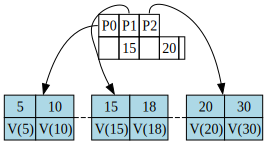

#### 3(b).2 After deleting 18 (Siblings at Min)

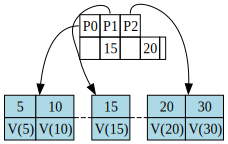

#### 3(b).3 After deleting 15, Underflow occurs (Borrowed from Left)

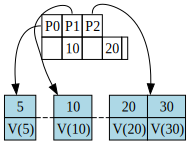

In [8]:
# --- Initialize Tree for Borrow Left Demo ---
print("--- Scenario 3b: Borrow Left ---")
tree_borrow_left = BPlusTree(order=4)
keys_setup = [10, 20, 30, 5, 15, 18] 
print(f"\nInserting {keys_setup}...")
for k in keys_setup: tree_borrow_left.insert(k, f"Val_{k}")
visualize_and_display(tree_borrow_left, "3(b).1: Initial State for Deletion")

# Delete keys from middle node until underflow
key_del_1 = 18
deleted = tree_borrow_left.delete(key_del_1)
visualize_and_display(tree_borrow_left, f"3(b).2 After deleting {key_del_1} (Siblings at Min)")

key_del_2 = 15
deleted = tree_borrow_left.delete(key_del_2)
visualize_and_display(tree_borrow_left, f"3(b).3 After deleting {key_del_2}, Underflow occurs (Borrowed from Left)")

### 4. Deletion Scenario: Merging Leaf Nodes (Order 4)

This sequence demonstrates a deletion causing underflow where neither sibling can lend (both are at minimum capacity), forcing a **merge** of leaf nodes. We use `order=4` (min 1 key/node).

1.  **Setup State:** First, insert keys `[10, 20, 5, 15, 25, 30]`.
2.  **Make sibiling nodes min:**Then delete keys `[5, 20, 30]` using `**delete()**` multiple times. State before merge trigger (`4.2`) is Root `[15, 25]`, Leaves `[10]`, `[15]`, `[25]`.
3.  **Delete `15` (Triggers Merge):** Call to `**delete(15)**`. Deleting key `15` from leaf `[15]` causes underflow (`[]`). `delete` calls `**_handle_underflow**` on `[]`.
    *   `**_handle_underflow**` called for `[]` (child index 1 of root `[15, 25]`).
    *   Checks Left Sibling `[10]` (index 0). Has 1 key (minimum). Cannot borrow.
    *   Checks Right Sibling `[25]` (index 2). Has 1 key (minimum). Cannot borrow.
    *   Merge is required. `**_handle_underflow**` calls `**_merge_nodes**`. Assume implementation merges the underflowing node `[]` into its left sibling `[10]`.
    *   `**_merge_nodes(left=[10], right=[], parent=[15, 25], left_node_idx=0)` executes:
        *   Separator key `15` removed from parent `[15, 25]`. Parent becomes `[25]`.
        *   Pointer to `[]` (at index 1) removed from parent values.
        *   Keys/values from `[]` added to `[10]`. Merged leaf remains `[10]`.
        *   `next_leaf` of `[10]` updated to point to `[25]`.
    *   Parent `[25]` (the root) has 1 key and 2 children (`[10]`, `[25]`). It does not underflow.
    *   **Result:** The merge is successful, and the parent is updated. Tree height remains the same. Final state shown in `4.3`.

--- Scenario 4: Merge Leaves & Root Change ---


#### 4.1: Initial State for Merge Demo

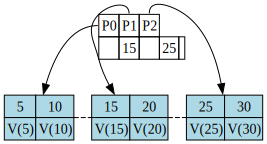


Deleting keys [5, 20, 30] to set up minimum leaves...


#### 4.2: State before Merge Trigger (Siblings at Min)

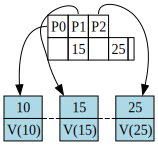

#### 4.3: State After Deleting 15 (Merge Occurred)

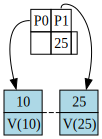

In [9]:
# --- Initialize Tree for Scenario 4 ---
print("--- Scenario 4: Merge Leaves & Root Change ---")
tree4 = BPlusTree(order=4)
keys_ins = [10, 20, 5, 15, 25, 30] 
for k in keys_ins: tree4.insert(k, f"Val_{k}")
visualize_and_display(tree4, f"4.1: Initial State for Merge Demo")

keys_del_setup = [5, 20, 30] 
print(f"\nDeleting keys {keys_del_setup} to set up minimum leaves...")
for k in keys_del_setup:
    deleted = tree4.delete(k)
visualize_and_display(tree4, "4.2: State before Merge Trigger (Siblings at Min)")

# Delete key causing underflow where siblings cannot lend
key_del_merge = 15
deleted = tree4.delete(key_del_merge)
visualize_and_display(tree4, f"4.3: State After Deleting {key_del_merge} (Merge Occurred)")

### 4(b). Deletion Scenario: Merging Leaf Nodes (Order 5 - Explicit Result)

This sequence uses `order=5` (min 2 keys/node) to make the result of the merge more visually distinct. It demonstrates deletion causing underflow where neighbors cannot lend, forcing a merge.

1.  **Setup State:** Insert keys `[10, 20, 30, 5, 15, 25, 35]`. State shown in `4(b).1`.
2.  **Prepare for Merge:** Delete key `25` using `**delete(25)**`. Leaf `[25, 30, 35]` becomes `[30, 35]` (min 2 keys). State before merge trigger shown in `4(b).2`.
3.  **Delete `15` (Triggers Merge):** Call to `**delete(15)**`. Deleting key `15` from leaf `[15, 20]` causes underflow (`[20]`, 1 key < min 2). `delete` calls `**_handle_underflow**` on `[20]`.
    *   `**_handle_underflow**` called for `[20]` (child index 1 of root `[15, 25]`).
    *   Checks Left Sibling `[5, 10]` (Index 0). Has 2 keys (minimum). Cannot borrow.
    *   Checks Right Sibling `[30, 35]` (Index 2). Has 2 keys (minimum). Cannot borrow.
    *   Merge required. `**_handle_underflow**` calls `**_merge_nodes**`. Merges underflowing node `[20]` into its left sibling `[5, 10]`.
    *   `**_merge_nodes(left=[5, 10], right=[20], parent=[15, 25], left_node_idx=0)` executes:
        *   Separator key `15` removed from parent `[15, 25]`. Parent becomes `[25]`.
        *   Pointer to `[20]` (at index 1) removed from parent values.
        *   Keys/values from `[20]` added to `[5, 10]`. Merged leaf becomes `[5, 10, 20]`.
        *   `next_leaf` updated.
    *   Parent `[25]` (the root) has 1 key and 2 children (`[5, 10, 20]`, `[30, 35]`). It does not underflow (root min keys = 1).
    *   **Result:** The merge is successful. The merged leaf `[5, 10, 20]` clearly shows keys from both original nodes. Final state shown in `4(b).3`.

--- Scenario 4b: Merge Leaves (Order 5) for explicitly noticing merge ---
(Using order=5, min_keys=2)

Setting up state for Merge Demo (order=5)...


#### 4(b).1: State after initial insertions

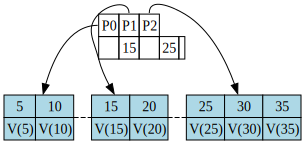

#### 4(b).2: State before Merge Trigger After Deleting 25 (Siblings at Min)

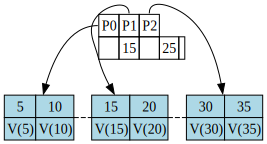

#### 4(b).3: State After Deleting 15 (Merge Occurred)

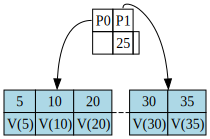

In [10]:
# --- Initialize Tree for Scenario 4b ---
print("--- Scenario 4b: Merge Leaves (Order 5) for explicitly noticing merge ---")
new_order = 5
tree4 = BPlusTree(order=new_order)
print(f"(Using order={new_order}, min_keys={math.ceil(new_order / 2) - 1})")

print("\nSetting up state for Merge Demo (order=5)...")
keys_ins = [10, 20, 30, 5, 15, 25, 35]
for k in keys_ins: tree4.insert(k, f"Val_{k}")
visualize_and_display(tree4, "4(b).1: State after initial insertions")

# Delete keys to leave relevant siblings at minimum (2 keys)
key_del_merge = 25
deleted = tree4.delete(key_del_merge)
visualize_and_display(tree4, f"4(b).2: State before Merge Trigger After Deleting {key_del_merge} (Siblings at Min)")

# Delete key causing underflow where siblings cannot lend
key_del_merge2 = 15
deleted = tree4.delete(key_del_merge2)
visualize_and_display(tree4, f"4(b).3: State After Deleting {key_del_merge2} (Merge Occurred)")

# Comparision

In [ ]:
# --- Configuration ---
B_TREE_ORDER = 50  # Use a realistic order (e.g., 50 or higher)
SIZES_TO_TEST = list(range(100, 100000, 10000))
NUM_RANGE_QUERIES_PER_SIZE = 100
DELETE_PERCENTAGE = 50 # Percentage of inserted keys to delete in the delete test

print(f"Using B+Tree Order: {B_TREE_ORDER}")
print(f"Testing sizes: {SIZES_TO_TEST}")

# --- Initialization ---
analyzer = PerformanceAnalyzer(btree_order=B_TREE_ORDER)
# Use descriptive keys matching the plots
results = {
    'size': [],
    'B+ Tree Insert Time': [], 'Brute Force Insert Time': [],
    'B+ Tree Search Time': [], 'Brute Force Search Time': [],
    'B+ Tree Range Query Time': [], 'Brute Force Range Query Time': [],
    'B+ Tree Deletion Time': [], 'Brute Force Deletion Time': [],
    'B+ Tree Memory After Insert': [], 'Brute Force Memory After Insert': [],
    'B+ Tree Memory After Delete': [], 'Brute Force Memory After Delete': []
}

# --- Run Benchmarks ---
print("\n--- Starting Benchmarks ---")
for size in SIZES_TO_TEST:
    print(f"\nProcessing Size: {size}...")
    results['size'].append(size)
    btree = None # Ensure btree is reset or defined before try block

    try:
        # 1. Insertion Test
        # print("  Running Insertion Test...")
        insert_res, btree, bf_db, inserted_keys = analyzer.run_insertion_test(size)
        results['B+ Tree Insert Time'].append(insert_res['bplus_insert_time'])
        results['Brute Force Insert Time'].append(insert_res['bf_insert_time'])
        results['B+ Tree Memory After Insert'].append(insert_res['bplus_memory_after_insert'])
        results['Brute Force Memory After Insert'].append(insert_res['bf_memory_after_insert'])
        # print(f"    B+ Tree Insert: {insert_res['bplus_insert_time']:.4f}s")

        if not inserted_keys:
            print("    WARNING: No keys inserted, skipping subsequent tests for this size.")
            results['B+ Tree Search Time'].append(0)
            results['Brute Force Search Time'].append(0)
            results['B+ Tree Range Query Time'].append(0)
            results['Brute Force Range Query Time'].append(0)
            results['B+ Tree Deletion Time'].append(0)
            results['Brute Force Deletion Time'].append(0)
            results['B+ Tree Memory After Delete'].append(insert_res['bplus_memory_after_insert'])
            results['Brute Force Memory After Delete'].append(insert_res['bf_memory_after_insert'])
            continue

        # 2. Search Test (Search all inserted keys)
        # print("  Running Search Test...")
        search_res = analyzer.run_search_test(btree, bf_db, inserted_keys)
        results['B+ Tree Search Time'].append(search_res['bplus_search_time'])
        results['Brute Force Search Time'].append(search_res['bf_search_time'])
        # print(f"    B+ Tree Search: {search_res['bplus_search_time']:.4f}s")


        # 3. Range Query Test
        # print("  Running Range Query Test...")
        range_res = analyzer.run_range_query_test(btree, bf_db, inserted_keys, num_queries=NUM_RANGE_QUERIES_PER_SIZE)
        results['B+ Tree Range Query Time'].append(range_res['bplus_range_time'])
        results['Brute Force Range Query Time'].append(range_res['bf_range_time'])
        # print(f"    B+ Tree Range: {range_res['bplus_range_time']:.4f}s")


        # 4. Deletion Test (Delete a percentage)
        # print("  Running Deletion Test...")
        num_to_delete = int(len(inserted_keys) * (DELETE_PERCENTAGE / 100.0))
        # Ensure we don't try to sample more keys than exist
        keys_to_delete = random.sample(inserted_keys, k=min(num_to_delete, len(inserted_keys)))
        delete_res = analyzer.run_delete_test(btree, bf_db, keys_to_delete)
        results['B+ Tree Deletion Time'].append(delete_res['bplus_delete_time'])
        results['Brute Force Deletion Time'].append(delete_res['bf_delete_time'])
        results['B+ Tree Memory After Delete'].append(delete_res['bplus_memory_after_delete'])
        results['Brute Force Memory After Delete'].append(delete_res['bf_memory_after_delete'])
        # print(f"    B+ Tree Delete: {delete_res['bplus_delete_time']:.4f}s")


    except Exception as e:
        print(f"ERROR occurred during processing for size: {size}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error message: {e}")
        num_results = len(results['size'])
        for key in results:
             if len(results[key]) < num_results:
                  results[key].append(None) # Or float('nan')

        print("\nBenchmark loop stopped due to error.")
        break 
print("\n--- Benchmarking Complete (or stopped on error) ---")

Using B+Tree Order: 50
Testing sizes: [100, 10100, 20100, 30100, 40100, 50100, 60100, 70100, 80100, 90100]


TypeError: PerformanceAnalyzer.__init__() got an unexpected keyword argument 'btree_order'

Generating plots...


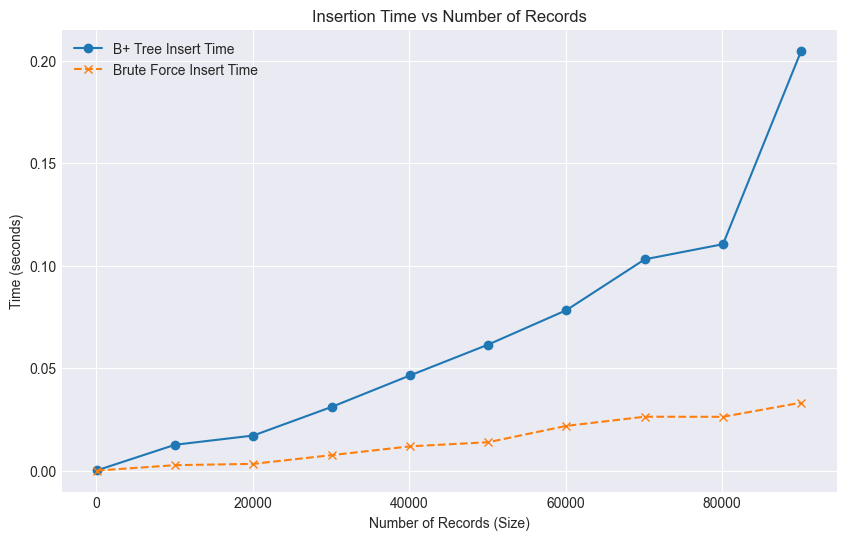

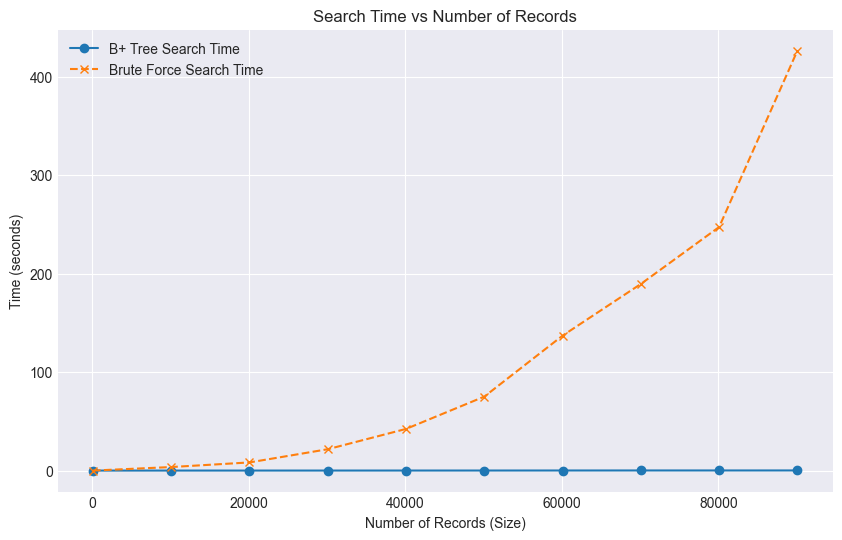

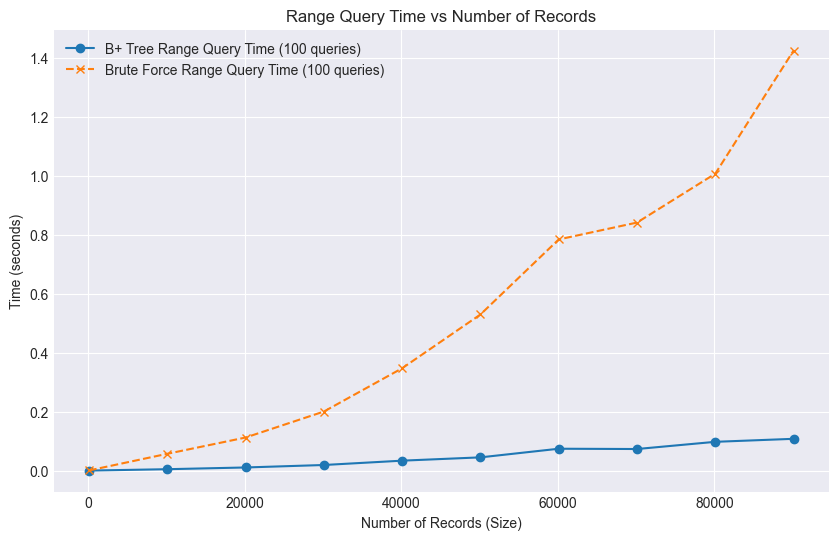

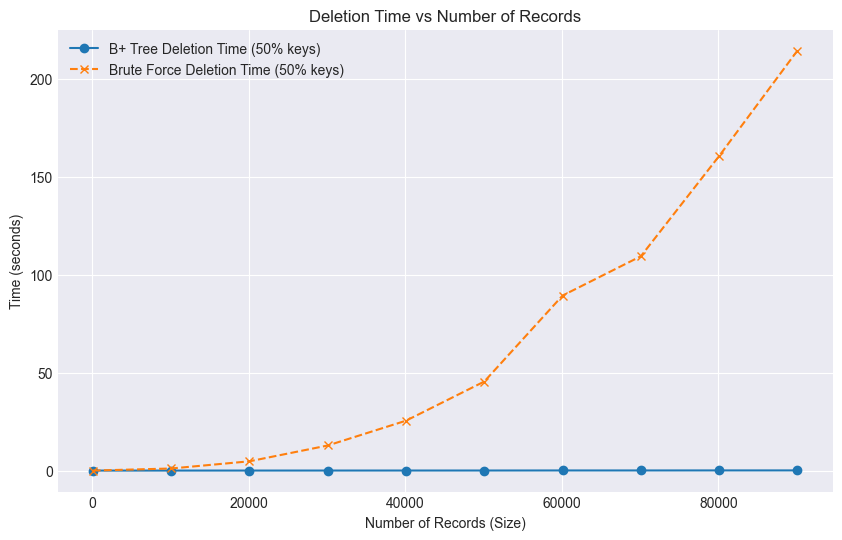

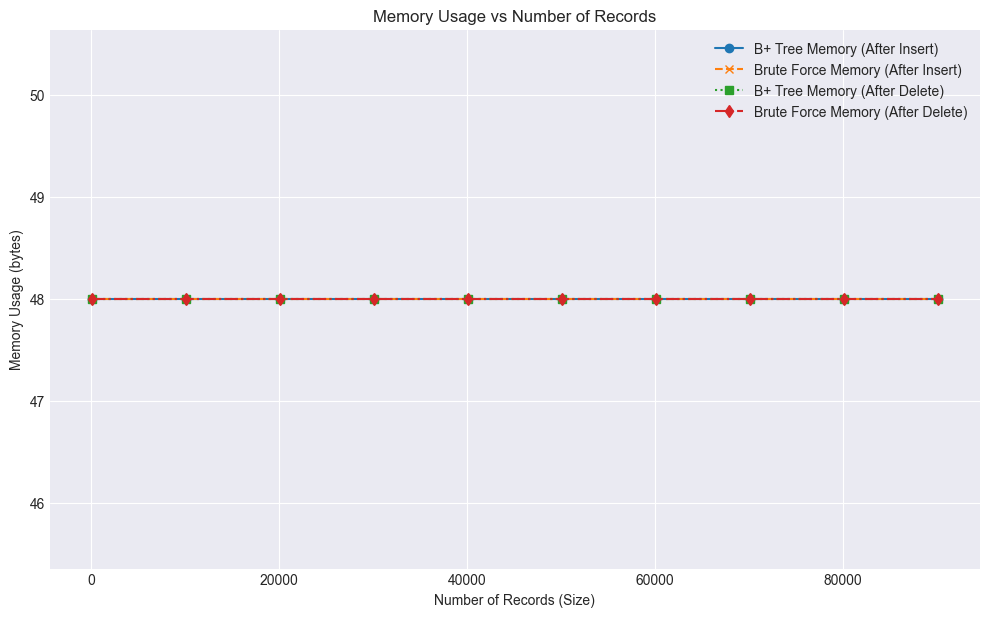

--- Plotting Complete ---


In [ ]:
# --- Visualize Results ---
print("Generating plots...")
plt.style.use('seaborn-v0_8-darkgrid')

# Filter out None values if errors occurred
valid_indices = [i for i, t in enumerate(results['B+ Tree Insert Time']) if t is not None]
plot_sizes = [results['size'][i] for i in valid_indices]
if not plot_sizes:
     print("No valid data to plot.")
else:
    # Plot 1: Insertion Time
    plt.figure(figsize=(10, 6))
    plt.plot(plot_sizes, [results['B+ Tree Insert Time'][i] for i in valid_indices], marker='o', linestyle='-', label='B+ Tree Insert Time')
    plt.plot(plot_sizes, [results['Brute Force Insert Time'][i] for i in valid_indices], marker='x', linestyle='--', label='Brute Force Insert Time')
    plt.xlabel("Number of Records (Size)")
    plt.ylabel("Time (seconds)")
    plt.title("Insertion Time vs Number of Records")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Search Time
    plt.figure(figsize=(10, 6))
    plt.plot(plot_sizes, [results['B+ Tree Search Time'][i] for i in valid_indices], marker='o', linestyle='-', label='B+ Tree Search Time')
    plt.plot(plot_sizes, [results['Brute Force Search Time'][i] for i in valid_indices], marker='x', linestyle='--', label='Brute Force Search Time')
    plt.xlabel("Number of Records (Size)")
    plt.ylabel("Time (seconds)")
    plt.title("Search Time vs Number of Records")
    # plt.yscale('log') # Consider log scale if times differ greatly
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 3: Range Query Time
    plt.figure(figsize=(10, 6))
    plt.plot(plot_sizes, [results['B+ Tree Range Query Time'][i] for i in valid_indices], marker='o', linestyle='-', label=f'B+ Tree Range Query Time ({NUM_RANGE_QUERIES_PER_SIZE} queries)')
    plt.plot(plot_sizes, [results['Brute Force Range Query Time'][i] for i in valid_indices], marker='x', linestyle='--', label=f'Brute Force Range Query Time ({NUM_RANGE_QUERIES_PER_SIZE} queries)')
    plt.xlabel("Number of Records (Size)")
    plt.ylabel("Time (seconds)")
    plt.title("Range Query Time vs Number of Records")
    # plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 4: Deletion Time
    plt.figure(figsize=(10, 6))
    plt.plot(plot_sizes, [results['B+ Tree Deletion Time'][i] for i in valid_indices], marker='o', linestyle='-', label=f'B+ Tree Deletion Time ({DELETE_PERCENTAGE}% keys)')
    plt.plot(plot_sizes, [results['Brute Force Deletion Time'][i] for i in valid_indices], marker='x', linestyle='--', label=f'Brute Force Deletion Time ({DELETE_PERCENTAGE}% keys)')
    plt.xlabel("Number of Records (Size)")
    plt.ylabel("Time (seconds)")
    plt.title("Deletion Time vs Number of Records")
    # plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 5: Memory Usage
    plt.figure(figsize=(12, 7))
    plt.plot(plot_sizes, [results['B+ Tree Memory After Insert'][i] for i in valid_indices], marker='o', linestyle='-', label='B+ Tree Memory (After Insert)')
    plt.plot(plot_sizes, [results['Brute Force Memory After Insert'][i] for i in valid_indices], marker='x', linestyle='--', label='Brute Force Memory (After Insert)')
    plt.plot(plot_sizes, [results['B+ Tree Memory After Delete'][i] for i in valid_indices], marker='s', linestyle=':', label='B+ Tree Memory (After Delete)')
    plt.plot(plot_sizes, [results['Brute Force Memory After Delete'][i] for i in valid_indices], marker='d', linestyle='-.', label='Brute Force Memory (After Delete)')
    plt.xlabel("Number of Records (Size)")
    plt.ylabel("Memory Usage (bytes)")
    plt.title("Memory Usage vs Number of Records")
    plt.legend()
    plt.grid(True)
    plt.show()

print("--- Plotting Complete ---")

In [4]:
# --- Configuration ---
ORDERS_TO_TEST = [5]
SIZES_TO_TEST = list(range(100, 50000, 10000)) # e.g., 100, 10100, ..., 50100
DELETE_PERCENTAGE_FOR_TEST = 30 # For delete timing test
MIX_OPS_FACTOR = 0.5 # Mix ops = 50% of data size
NUM_RANGE_QUERIES = 100 # For range query timing test

print(f"Testing B+Tree Orders: {ORDERS_TO_TEST}")
print(f"Testing sizes: {SIZES_TO_TEST}")

# --- Initialization ---
analyzer = PerformanceAnalyzer() 
results_list = [] 

# --- Run Benchmarks ---
print("\n--- Starting Benchmarks ---")
for order in ORDERS_TO_TEST:
    print(f"\n===== TESTING ORDER: {order} =====")
    for size in SIZES_TO_TEST:
        print(f"\n  Processing Size: {size}...")
        # Store config for this run
        run_config = {'order': order, 'size': size}
        combined_results = {}
        combined_results.update(run_config)

        try:
            # 1. Insertion Memory/Time Test
            insert_mem_results = analyzer.run_insertion_memory_time_test(size, order)
            combined_results.update(insert_mem_results)

            # 2. Search Time Test
            search_results = analyzer.run_search_test(size, order)
            combined_results.update(search_results)

            # 3. Range Query Time Test
            range_results = analyzer.run_range_query_test(size, order, num_queries=NUM_RANGE_QUERIES)
            combined_results.update(range_results)

            # 4. Deletion Time Test
            delete_results = analyzer.run_delete_test(size, order, delete_percentage=DELETE_PERCENTAGE_FOR_TEST)
            combined_results.update(delete_results)

            # 5. Random Mix Time Test
            mix_results = analyzer.run_random_mix_test(size, order, num_operations_factor=MIX_OPS_FACTOR)
            combined_results.update(mix_results)

            results_list.append(combined_results) # Add complete results for this run

        except Exception as e:
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"ERROR occurred during processing for size: {size}, order: {order}")
            print(f"Error type: {type(e).__name__}")
            print(f"Error message: {e}")
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            results_list.append({**run_config, **combined_results}) # Store what we have
            print("\nBenchmark loop may continue, but data for this point is incomplete.")

print("\n--- Benchmarking Complete ---")

Testing B+Tree Orders: [5]
Testing sizes: [100, 10100, 20100, 30100, 40100]

--- Starting Benchmarks ---

===== TESTING ORDER: 5 =====

  Processing Size: 100...
    Running Insert/Memory Test (Size: 100, Order: 5)...
      Peaks (BF/B+U/B+S): 912/13496/19152 bytes
    Running Search Test (Size: 100, Order: 5)...
      Search (B+/BF): 0.0001s / 0.0002s
    Running Range Test (Size: 100, Order: 5)...
      Range (B+/BF): 0.0004s / 0.0005s
    Running Delete Test (Size: 100, Order: 5)...
      Delete (B+/BF): 0.0001s / 0.0001s
    Running Mix Test (Size: 100, Order: 5)...
      Mix (B+/BF): 0.0001s / 0.0001s

  Processing Size: 10100...
    Running Insert/Memory Test (Size: 10100, Order: 5)...
      Peaks (BF/B+U/B+S): 650824/1463659/2017088 bytes
    Running Search Test (Size: 10100, Order: 5)...
      Search (B+/BF): 0.0022s / 0.6322s
    Running Range Test (Size: 10100, Order: 5)...
      Range (B+/BF): 0.0635s / 0.0633s
    Running Delete Test (Size: 10100, Order: 5)...
      Delete 


--- Results Summary (DataFrame) ---


,order,size,bplus_insert_time_unsorted,bplus_insert_time_sorted,bf_insert_time,bplus_peak_mem_unsorted_MB,bplus_peak_mem_sorted_MB,bf_peak_mem_MB,bplus_search_time,bf_search_time,bplus_range_time,bf_range_time,bplus_delete_time,bf_delete_time,bplus_mix_time,bf_mix_time
0,5,100,0.0011,0.0007,0.0001,0.0129,0.0183,0.0009,0.0001,0.0002,0.0004,0.0005,0.0001,0.0001,0.0001,0.0001
1,5,10100,0.0854,0.1696,0.0171,1.3959,1.9236,0.6207,0.0022,0.6322,0.0635,0.0633,0.0058,1.1375,0.0157,1.0658
2,5,20100,0.2920,0.2120,0.0160,2.7935,3.8286,1.2385,0.0066,2.9875,0.0185,0.1936,0.0203,5.4270,0.0293,6.9391
3,5,30100,0.4591,0.5001,0.0430,4.1673,5.7365,1.8426,0.0165,7.4664,0.0509,0.4321,0.0287,14.2875,0.0697,18.2358
4,5,40100,0.4277,0.6021,0.0485,5.5578,7.6441,2.4764,0.0382,35.2093,0.1045,1.3343,0.1266,60.5810,0.1708,50.0526



--- Generating Plots ---


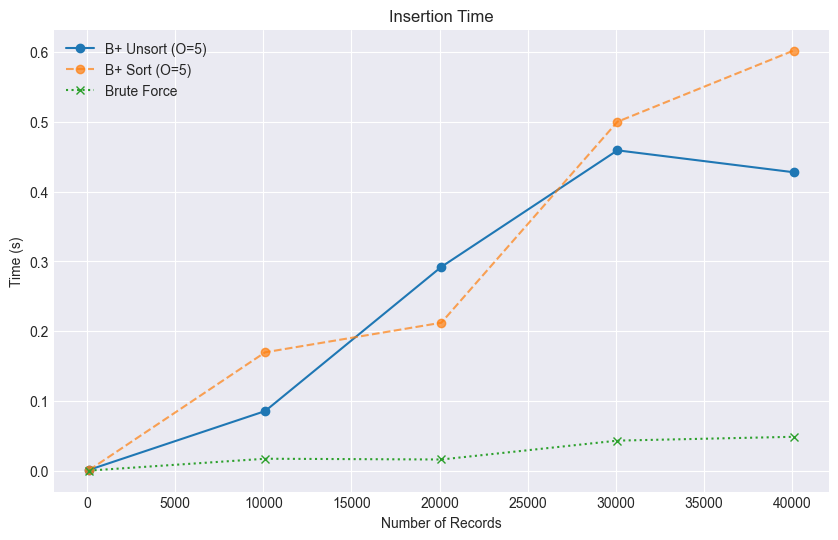

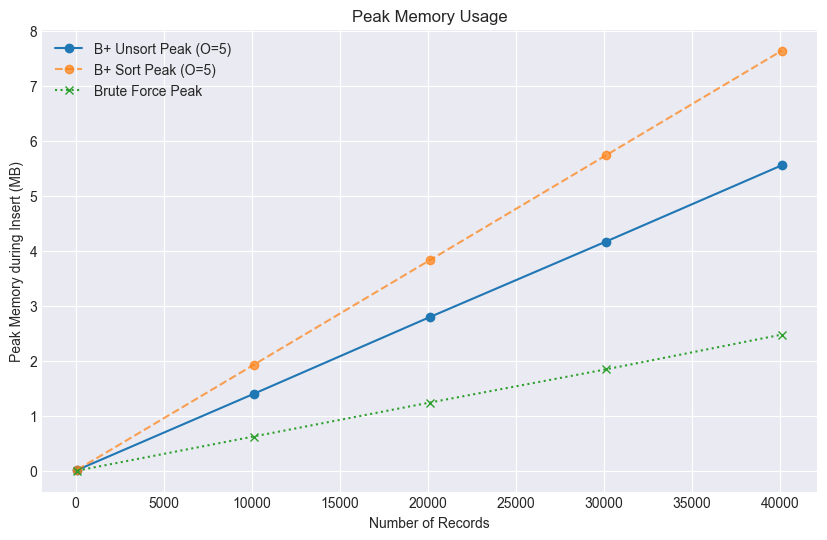

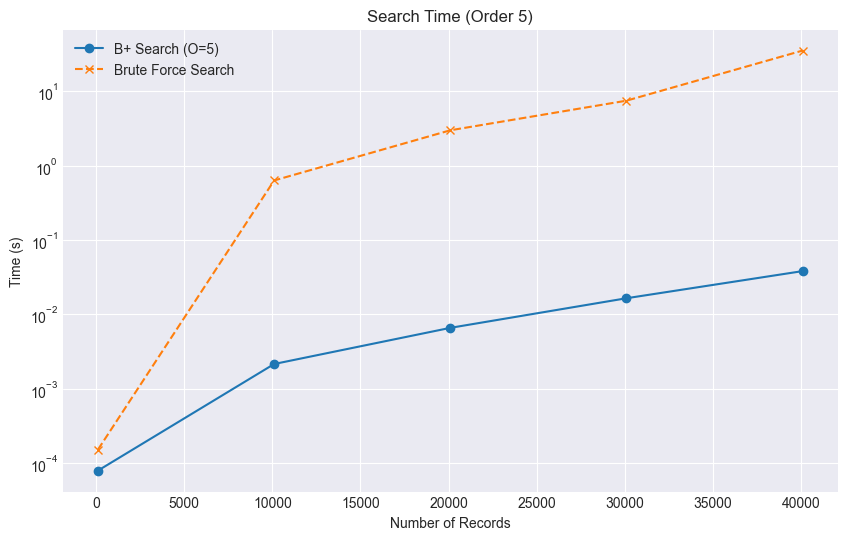

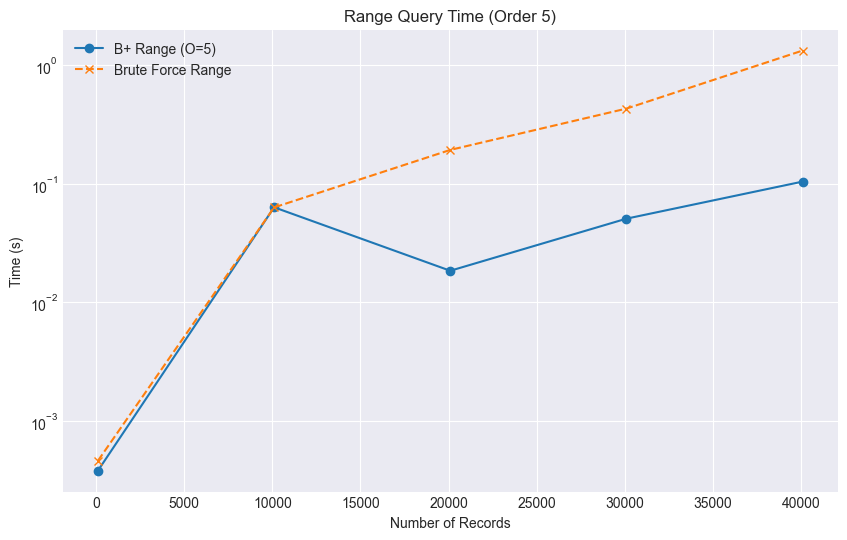

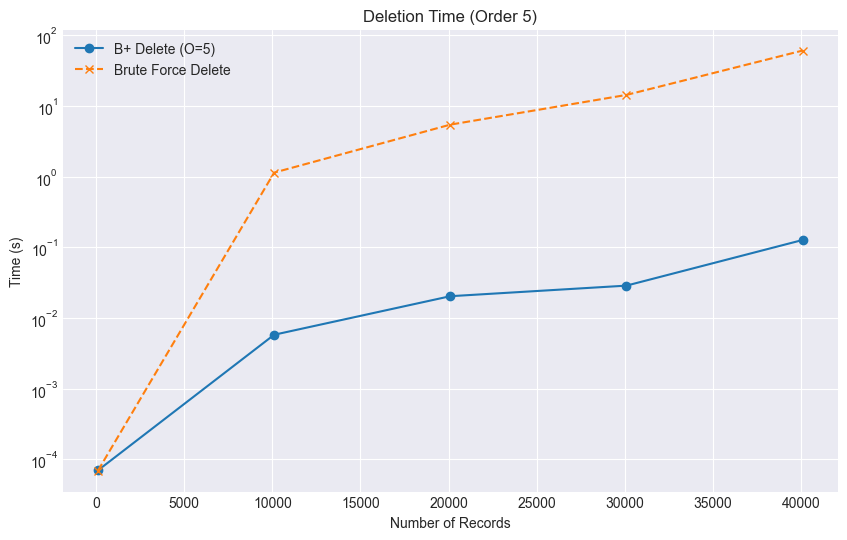

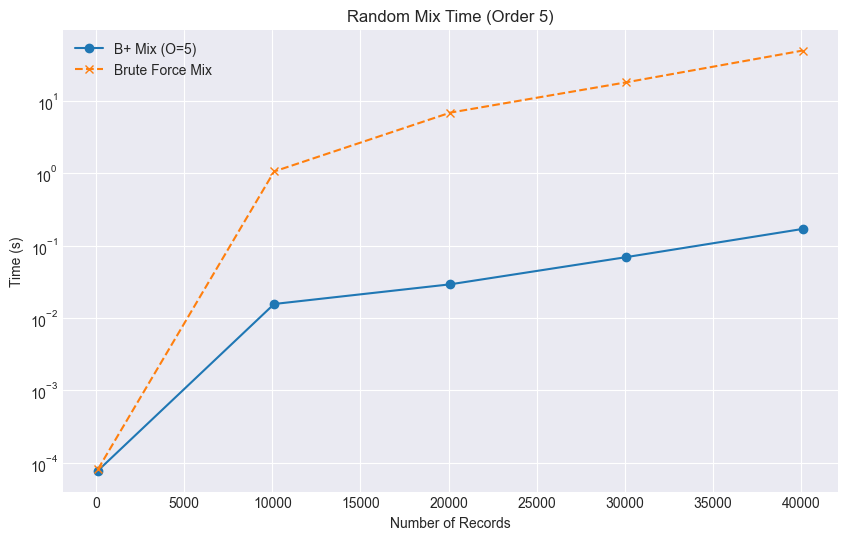


--- Plotting Complete ---


In [5]:
#  --- Process Results into DataFrame ---
if not results_list:
    print("No results collected.")
else:
    df_results = pd.DataFrame(results_list)
    # Fill missing values that might occur from errors
    df_results = df_results.fillna(value=np.nan) # Use NaN for missing numerics

    # Convert memory to MB for readability
    mem_cols = ['bf_peak_mem', 'bplus_peak_mem_unsorted', 'bplus_peak_mem_sorted']
    for col in mem_cols:
        if col in df_results.columns:
            df_results[f'{col}_MB'] = df_results[col] / (1024 * 1024)

    print("\n--- Results Summary (DataFrame) ---")
    display_cols = [ # Define desired columns
        'order', 'size',
        'bplus_insert_time_unsorted', 'bplus_insert_time_sorted', 'bf_insert_time',
        'bplus_peak_mem_unsorted_MB', 'bplus_peak_mem_sorted_MB', 'bf_peak_mem_MB',
        'bplus_search_time', 'bf_search_time', 'bplus_range_time', 'bf_range_time',
        'bplus_delete_time', 'bf_delete_time', 'bplus_mix_time', 'bf_mix_time'
    ]
    display_cols = [col for col in display_cols if col in df_results.columns] # Ensure columns exist
    # Use display() for better notebook rendering of DataFrame
    display(df_results[display_cols].round(4))
    # print(df_results[display_cols].round(4).to_string()) # Alternative for full output

    # --- Visualize Results ---
    print("\n--- Generating Plots ---")
    plt.style.use('seaborn-v0_8-darkgrid')
    grouped = df_results.groupby('order')
    markers = ['o', 's', '^', 'd', 'v']
    styles = ['-', '--', ':', '-.']

    # Plot 1: Insertion Time vs Size (Comparing Orders)
    plt.figure(figsize=(10, 6))
    for i, (order, group) in enumerate(grouped):
        plt.plot(group['size'], group['bplus_insert_time_unsorted'], marker=markers[i%len(markers)], linestyle=styles[0], label=f'B+ Unsort (O={order})')
        plt.plot(group['size'], group['bplus_insert_time_sorted'], marker=markers[i%len(markers)], linestyle=styles[1], alpha=0.7, label=f'B+ Sort (O={order})')
    bf_group = df_results.drop_duplicates(subset=['size'])
    plt.plot(bf_group['size'], bf_group['bf_insert_time'], marker='x', linestyle=styles[2], label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Insertion Time"); plt.legend(); plt.grid(True); plt.show()

    # Plot 2: Peak Memory Usage vs Size (Comparing Orders)
    plt.figure(figsize=(10, 6))
    for i, (order, group) in enumerate(grouped):
        plt.plot(group['size'], group['bplus_peak_mem_unsorted_MB'], marker=markers[i%len(markers)], linestyle=styles[0], label=f'B+ Unsort Peak (O={order})')
        plt.plot(group['size'], group['bplus_peak_mem_sorted_MB'], marker=markers[i%len(markers)], linestyle=styles[1], alpha=0.7, label=f'B+ Sort Peak (O={order})')
    plt.plot(bf_group['size'], bf_group['bf_peak_mem_MB'], marker='x', linestyle=styles[2], label='Brute Force Peak')
    plt.xlabel("Number of Records"); plt.ylabel("Peak Memory during Insert (MB)"); plt.title("Peak Memory Usage"); plt.legend(); plt.grid(True); plt.show()

    # Plot 3-6: Search, Range, Delete, Mix Time vs Size (Show for one representative order)
    rep_order = ORDERS_TO_TEST[len(ORDERS_TO_TEST)//2] # Pick middle order
    rep_data = df_results[df_results['order'] == rep_order].dropna() # Use data for representative order, drop rows with Nones
    if not rep_data.empty:
        # Search
        plt.figure(figsize=(10, 6))
        plt.plot(rep_data['size'], rep_data['bplus_search_time'], marker='o', linestyle=styles[0], label=f'B+ Search (O={rep_order})')
        plt.plot(rep_data['size'], rep_data['bf_search_time'], marker='x', linestyle=styles[1], label='Brute Force Search')
        plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title(f"Search Time (Order {rep_order})"); plt.legend(); plt.grid(True); plt.yscale('log'); plt.show()
        # Range
        plt.figure(figsize=(10, 6))
        plt.plot(rep_data['size'], rep_data['bplus_range_time'], marker='o', linestyle=styles[0], label=f'B+ Range (O={rep_order})')
        plt.plot(rep_data['size'], rep_data['bf_range_time'], marker='x', linestyle=styles[1], label='Brute Force Range')
        plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title(f"Range Query Time (Order {rep_order})"); plt.legend(); plt.grid(True); plt.yscale('log'); plt.show()
        # Delete
        plt.figure(figsize=(10, 6))
        plt.plot(rep_data['size'], rep_data['bplus_delete_time'], marker='o', linestyle=styles[0], label=f'B+ Delete (O={rep_order})')
        plt.plot(rep_data['size'], rep_data['bf_delete_time'], marker='x', linestyle=styles[1], label='Brute Force Delete')
        plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title(f"Deletion Time (Order {rep_order})"); plt.legend(); plt.grid(True); plt.yscale('log'); plt.show()
        # Mix
        plt.figure(figsize=(10, 6))
        plt.plot(rep_data['size'], rep_data['bplus_mix_time'], marker='o', linestyle=styles[0], label=f'B+ Mix (O={rep_order})')
        plt.plot(rep_data['size'], rep_data['bf_mix_time'], marker='x', linestyle=styles[1], label='Brute Force Mix')
        plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title(f"Random Mix Time (Order {rep_order})"); plt.legend(); plt.grid(True); plt.yscale('log'); plt.show()

    print("\n--- Plotting Complete ---")

--- Running Benchmark for B+Tree Order: 10 ---
Testing sizes: [100, 10100, 20100, 30100, 40100, 50100, 60100]

--- Starting Benchmarks ---

  Processing Size: 100...
    Running Insert/Memory Test (Size: 100, Order: 10)...
      Peaks (BF/B+U/B+S): 912/6616/7656 bytes
    Running Search Test (Size: 100, Order: 10)...
      Search (B+/BF): 0.0001s / 0.0002s
    Running Range Test (Size: 100, Order: 10)...
      Range (B+/BF): 0.0002s / 0.0007s
    Running Delete Test (Size: 100, Order: 10)...
      Delete (B+/BF): 0.0001s / 0.0001s
    Running Mix Test (Size: 100, Order: 10)...
      Mix (B+/BF): 0.0001s / 0.0001s

  Processing Size: 10100...
    Running Insert/Memory Test (Size: 10100, Order: 10)...
      Peaks (BF/B+U/B+S): 650824/699131/758216 bytes
    Running Search Test (Size: 10100, Order: 10)...
      Search (B+/BF): 0.0029s / 0.4735s
    Running Range Test (Size: 10100, Order: 10)...
      Range (B+/BF): 0.0050s / 0.0561s
    Running Delete Test (Size: 10100, Order: 10)...
    

,size,bplus_insert_time_unsorted,bplus_insert_time_sorted,bf_insert_time,bplus_peak_mem_unsorted_MB,bplus_peak_mem_sorted_MB,bf_peak_mem_MB
0,100,0.0007,0.0004,0.0001,0.0063,0.0073,0.0009
1,10100,0.0321,0.0295,0.0165,0.6667,0.7231,0.6207
2,20100,0.1237,0.0692,0.0198,1.3283,1.4404,1.2385
3,30100,0.6343,0.2734,0.1523,1.9839,2.1551,1.8426
4,40100,0.5100,0.3099,0.0818,2.6533,2.8715,2.4764
5,50100,0.2364,0.2584,0.0435,3.3177,3.5891,3.0995
6,60100,1.0012,0.9548,0.1491,3.9743,4.3061,3.6876


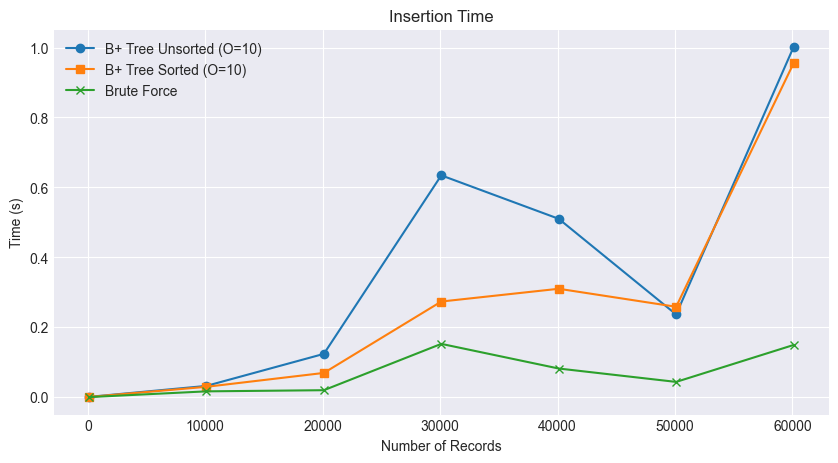

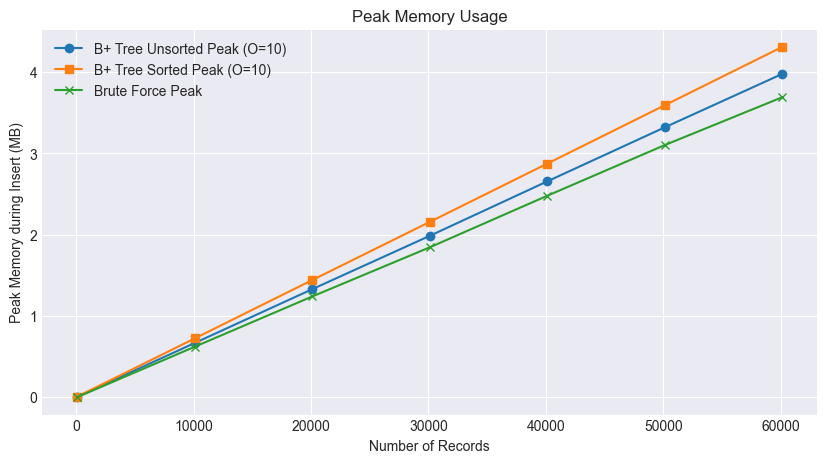


==================== Operation Timing Results ====================


,size,bplus_search_time,bf_search_time,bplus_range_time,bf_range_time,bplus_delete_time,bf_delete_time,bplus_mix_time,bf_mix_time
0,100,0.0001,0.0002,0.0002,0.0007,0.0001,0.0001,0.0001,0.0001
1,10100,0.0029,0.4735,0.0050,0.0561,0.0032,1.1296,0.0095,1.2783
2,20100,0.0043,2.2649,0.0299,0.2036,0.0090,4.7615,0.0443,17.2216
3,30100,0.0262,7.9316,0.0575,0.7090,0.3134,22.3033,0.2613,31.4336
4,40100,0.0312,26.6048,0.0652,1.4082,0.0591,30.1819,0.0624,30.4287
5,50100,0.0303,21.8928,0.0440,0.9014,0.0480,62.1233,0.1571,81.4881
6,60100,0.0952,88.8901,0.0506,0.8714,0.0389,55.4469,0.0723,76.6801


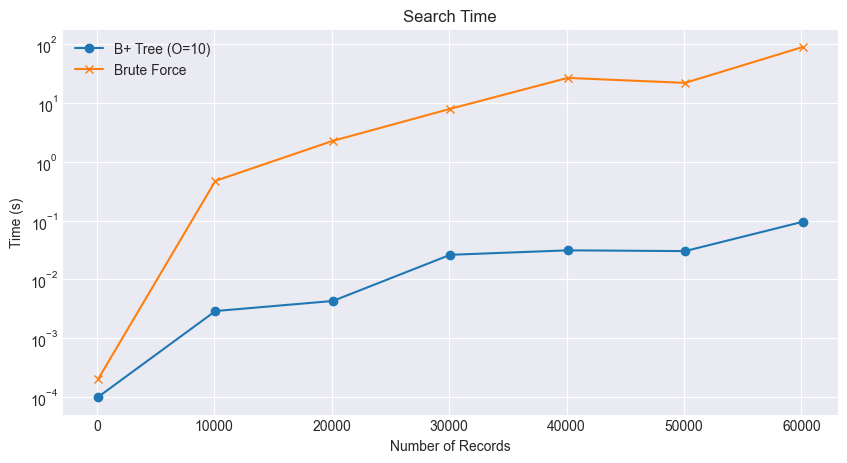

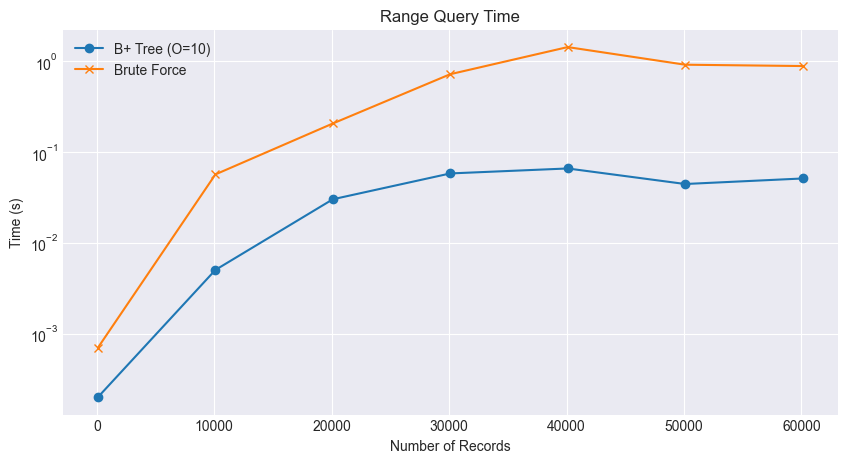

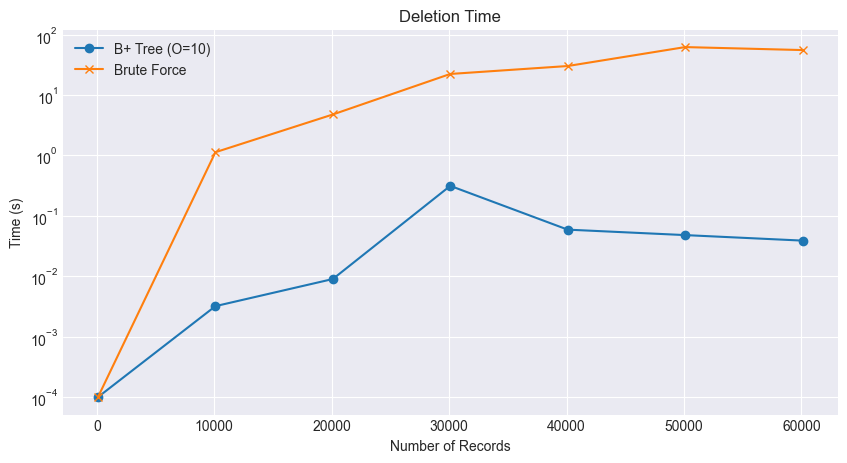

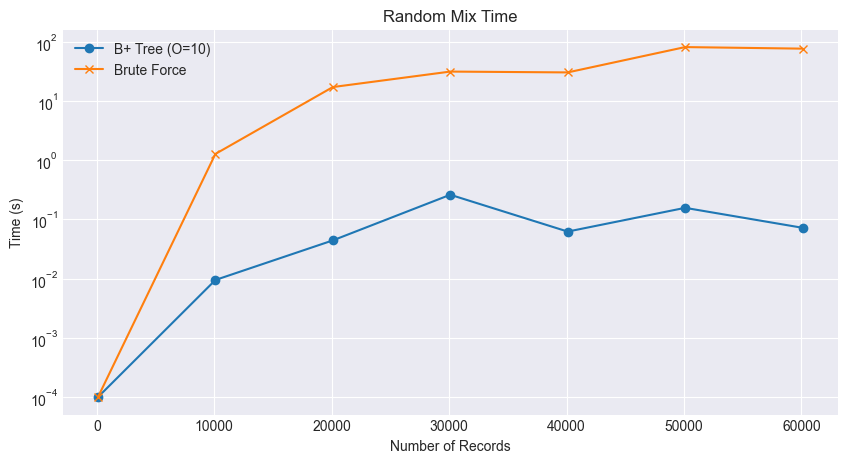


--- Analysis Complete ---


In [6]:
# --- Configuration ---
B_TREE_ORDER = 10 

SIZES_TO_TEST = list(range(100, 60101, 10000)) # e.g., 100, 10100, ..., 50100
# SIZES_TO_TEST = [100, 1000, 5000, 10000, 20000, 40000] # Alternative smaller set for speed

DELETE_PERCENTAGE_FOR_TEST = 30
MIX_OPS_FACTOR = 0.5
NUM_RANGE_QUERIES = 100

print(f"--- Running Benchmark for B+Tree Order: {B_TREE_ORDER} ---")
print(f"Testing sizes: {SIZES_TO_TEST}")

# --- Initialization ---
analyzer = PerformanceAnalyzer() # Analyzer itself doesn't need order
results_list = [] # Store results as a list of dictionaries

# --- Run Benchmarks ---
print("\n--- Starting Benchmarks ---")
# Removed outer loop for order
for size in SIZES_TO_TEST:
    print(f"\n  Processing Size: {size}...")
    run_config = {'order': B_TREE_ORDER, 'size': size} # Store config
    combined_results = {}
    combined_results.update(run_config)

    try:
        # 1. Insertion Memory/Time Test
        insert_mem_results = analyzer.run_insertion_memory_time_test(size, B_TREE_ORDER)
        combined_results.update(insert_mem_results)

        # 2. Search Time Test
        search_results = analyzer.run_search_test(size, B_TREE_ORDER)
        combined_results.update(search_results)

        # 3. Range Query Time Test
        range_results = analyzer.run_range_query_test(size, B_TREE_ORDER, num_queries=NUM_RANGE_QUERIES)
        combined_results.update(range_results)

        # 4. Deletion Time Test
        delete_results = analyzer.run_delete_test(size, B_TREE_ORDER, delete_percentage=DELETE_PERCENTAGE_FOR_TEST)
        combined_results.update(delete_results)

        # 5. Random Mix Time Test
        mix_results = analyzer.run_random_mix_test(size, B_TREE_ORDER, num_operations_factor=MIX_OPS_FACTOR)
        combined_results.update(mix_results)

        results_list.append(combined_results)

    except Exception as e:
        print(f"!!! ERROR during size: {size}, order: {B_TREE_ORDER} !!!")
        print(f"    {type(e).__name__}: {e}")
        results_list.append({**run_config, **combined_results}) # Store partial
        print("Benchmark loop may continue...")
        # break # Optional stop

print("\n--- Benchmarking Complete ---")

# --- Process Results into DataFrame ---
if not results_list:
    print("No results collected.")
else:
    df_results = pd.DataFrame(results_list).fillna(value=np.nan)
    # Convert memory to MB
    mem_cols = ['bf_peak_mem', 'bplus_peak_mem_unsorted', 'bplus_peak_mem_sorted']
    for col in mem_cols:
        if col in df_results.columns:
            df_results[f'{col}_MB'] = df_results[col] / (1024 * 1024)

    # --- Presentation: Insertion & Memory ---
    print("\n" + "="*20 + " Insertion & Memory Results " + "="*20)
    insert_mem_cols = [
        'size',
        'bplus_insert_time_unsorted', 'bplus_insert_time_sorted', 'bf_insert_time',
        'bplus_peak_mem_unsorted_MB', 'bplus_peak_mem_sorted_MB', 'bf_peak_mem_MB'
    ]
    insert_mem_cols = [col for col in insert_mem_cols if col in df_results.columns]
    df_insert_mem = df_results[insert_mem_cols].round(4)
    display(df_insert_mem) # Display table in notebook

    # Plot 1: Insertion Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_insert_mem['size'], df_insert_mem['bplus_insert_time_unsorted'], marker='o', label=f'B+ Tree Unsorted (O={B_TREE_ORDER})')
    plt.plot(df_insert_mem['size'], df_insert_mem['bplus_insert_time_sorted'], marker='s', label=f'B+ Tree Sorted (O={B_TREE_ORDER})')
    plt.plot(df_insert_mem['size'], df_insert_mem['bf_insert_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Insertion Time"); plt.legend(); plt.grid(True); plt.show()

    # Plot 2: Peak Memory Usage
    plt.figure(figsize=(10, 5))
    plt.plot(df_insert_mem['size'], df_insert_mem['bplus_peak_mem_unsorted_MB'], marker='o', label=f'B+ Tree Unsorted Peak (O={B_TREE_ORDER})')
    plt.plot(df_insert_mem['size'], df_insert_mem['bplus_peak_mem_sorted_MB'], marker='s', label=f'B+ Tree Sorted Peak (O={B_TREE_ORDER})')
    plt.plot(df_insert_mem['size'], df_insert_mem['bf_peak_mem_MB'], marker='x', label='Brute Force Peak')
    plt.xlabel("Number of Records"); plt.ylabel("Peak Memory during Insert (MB)"); plt.title("Peak Memory Usage"); plt.legend(); plt.grid(True); plt.show()


    # --- Presentation: Other Operations (Time) ---
    print("\n" + "="*20 + " Operation Timing Results " + "="*20)
    op_time_cols = [
        'size',
        'bplus_search_time', 'bf_search_time',
        'bplus_range_time', 'bf_range_time',
        'bplus_delete_time', 'bf_delete_time',
        'bplus_mix_time', 'bf_mix_time'
    ]
    op_time_cols = [col for col in op_time_cols if col in df_results.columns]
    df_op_times = df_results[op_time_cols].round(4)
    display(df_op_times) # Display table in notebook

    # Plot 3: Search Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_op_times['size'], df_op_times['bplus_search_time'], marker='o', label=f'B+ Tree (O={B_TREE_ORDER})')
    plt.plot(df_op_times['size'], df_op_times['bf_search_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Search Time"); plt.yscale('log'); plt.legend(); plt.grid(True); plt.show()

    # Plot 4: Range Query Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_op_times['size'], df_op_times['bplus_range_time'], marker='o', label=f'B+ Tree (O={B_TREE_ORDER})')
    plt.plot(df_op_times['size'], df_op_times['bf_range_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Range Query Time"); plt.yscale('log'); plt.legend(); plt.grid(True); plt.show()

    # Plot 5: Deletion Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_op_times['size'], df_op_times['bplus_delete_time'], marker='o', label=f'B+ Tree (O={B_TREE_ORDER})')
    plt.plot(df_op_times['size'], df_op_times['bf_delete_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Deletion Time"); plt.yscale('log'); plt.legend(); plt.grid(True); plt.show()

    # Plot 6: Random Mix Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_op_times['size'], df_op_times['bplus_mix_time'], marker='o', label=f'B+ Tree (O={B_TREE_ORDER})')
    plt.plot(df_op_times['size'], df_op_times['bf_mix_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Random Mix Time"); plt.yscale('log'); plt.legend(); plt.grid(True); plt.show()


print("\n--- Analysis Complete ---")

--- Running Benchmark for B+Tree Order: 10 ---
Testing sizes: [100, 10100, 20100, 30100, 40100, 50100, 60100]

--- Starting Benchmarks ---

  Processing Size: 100...
    Running Insert/Memory Test (Size: 100, Order: 10)...
      Peaks (BF/B+U/B+S): 912/8944/7680 bytes
    Running Search Test (Size: 100, Order: 10)...
      Search (B+/BF): 0.0001s / 0.0002s
    Running Range Test (Size: 100, Order: 10)...
      Range (B+/BF): 0.0002s / 0.0006s
    Running Delete Test (Size: 100, Order: 10)...
      Delete (B+/BF): 0.0000s / 0.0000s
    Running Mix Test (Size: 100, Order: 10)...
      Mix (B+/BF): 0.0000s / 0.0001s

  Processing Size: 10100...
    Running Insert/Memory Test (Size: 10100, Order: 10)...
      Peaks (BF/B+U/B+S): 652304/696891/754856 bytes
    Running Search Test (Size: 10100, Order: 10)...
      Search (B+/BF): 0.0016s / 0.3374s
    Running Range Test (Size: 10100, Order: 10)...
      Range (B+/BF): 0.0043s / 0.0555s
    Running Delete Test (Size: 10100, Order: 10)...
    

,size,bplus_insert_time_unsorted,bplus_insert_time_sorted,bf_insert_time,bplus_peak_mem_unsorted_MB,bplus_peak_mem_sorted_MB,bf_peak_mem_MB
0,100,0.0005,0.0003,0.0000,0.0085,0.0073,0.0009
1,10100,0.0214,0.0221,0.0483,0.6646,0.7199,0.6221
2,20100,0.0540,0.0496,0.0159,1.3252,1.4409,1.2385
3,30100,0.1511,0.0787,0.0216,1.9968,2.1549,1.8426
4,40100,0.2186,0.1176,0.0311,2.6537,2.8714,2.4764
5,50100,0.2673,0.1401,0.0468,3.3217,3.5885,3.0995
6,60100,0.3218,0.2503,0.0501,3.9788,4.3063,3.6865


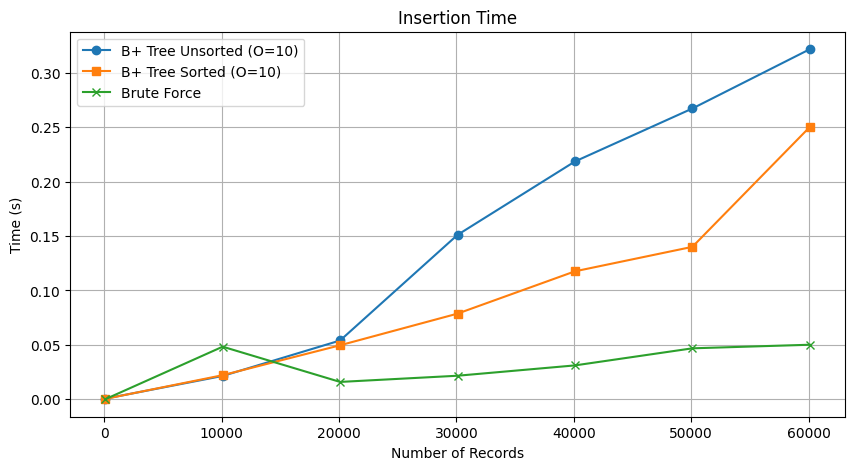

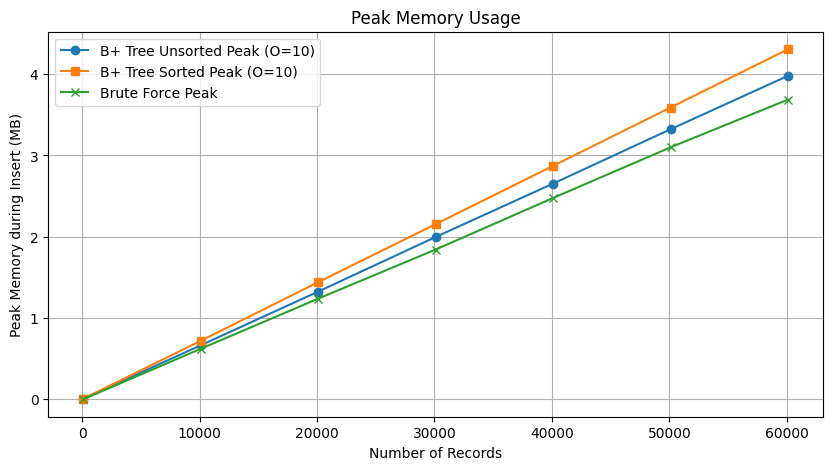


==================== Operation Timing Results ====================


,size,bplus_search_time,bf_search_time,bplus_range_time,bf_range_time,bplus_delete_time,bf_delete_time,bplus_mix_time,bf_mix_time
0,100,0.0001,0.0002,0.0002,0.0006,0.0000,0.0000,0.0000,0.0001
1,10100,0.0016,0.3374,0.0043,0.0555,0.0030,0.6593,0.0066,0.8574
2,20100,0.0056,1.7292,0.0613,0.1164,0.0087,3.3634,0.0158,4.2826
3,30100,0.0078,4.5941,0.0193,0.2775,0.0138,9.5104,0.0306,12.1241
4,40100,0.0129,9.5908,0.0312,0.4626,0.0251,19.8497,0.0651,25.5068
5,50100,0.0191,34.4865,0.0381,0.6096,0.0314,32.8091,0.0544,43.1596
6,60100,0.0217,26.2233,0.0517,0.8750,0.0480,53.8582,0.0702,85.5332


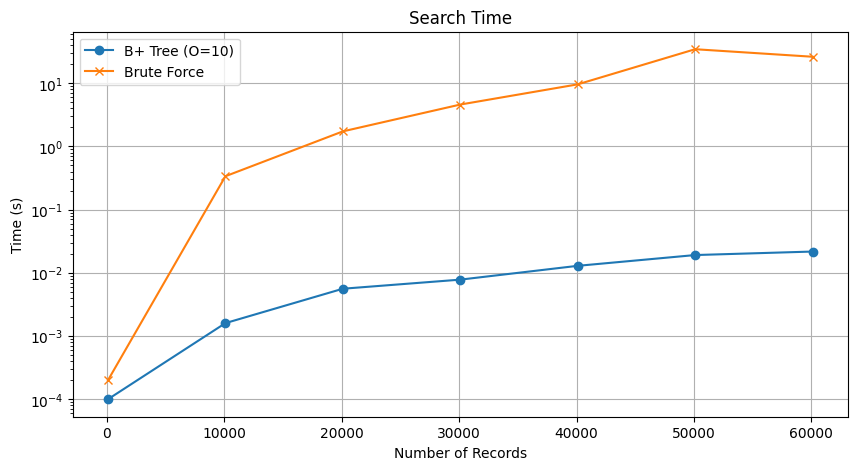

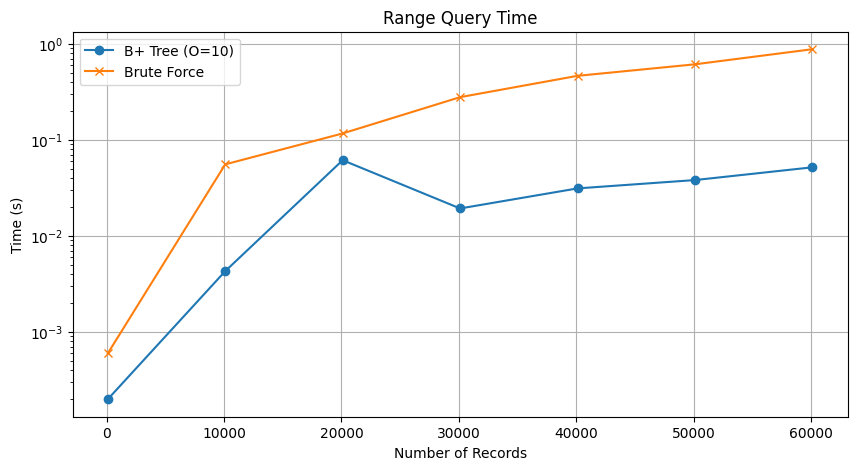

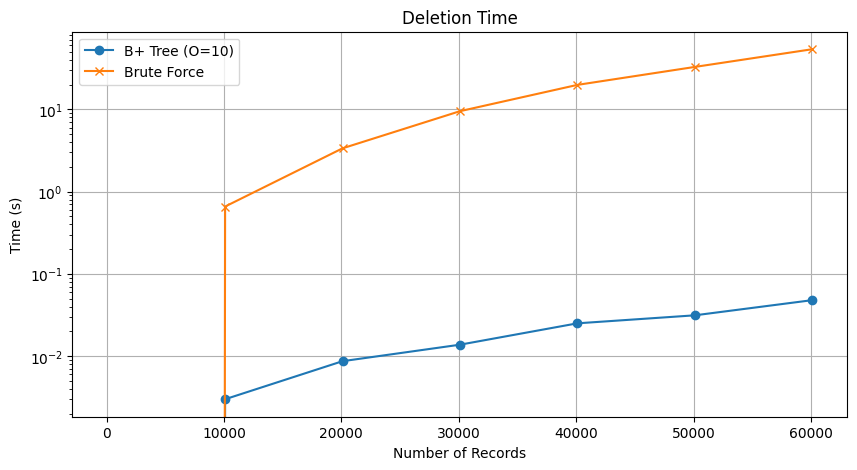

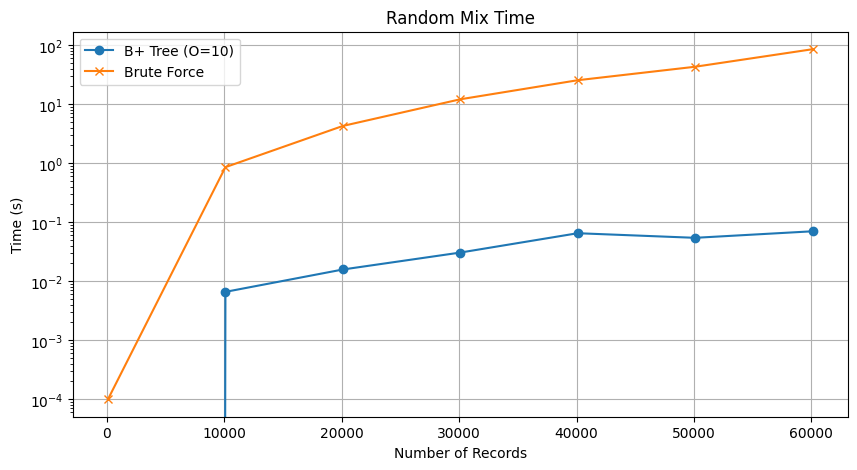


--- Analysis Complete ---


In [4]:
# --- Configuration ---
B_TREE_ORDER = 10 

SIZES_TO_TEST = list(range(100, 60101, 10000)) # e.g., 100, 10100, ..., 50100
# SIZES_TO_TEST = [100, 1000, 5000, 10000, 20000, 40000] # Alternative smaller set for speed

DELETE_PERCENTAGE_FOR_TEST = 30
MIX_OPS_FACTOR = 0.5
NUM_RANGE_QUERIES = 100

print(f"--- Running Benchmark for B+Tree Order: {B_TREE_ORDER} ---")
print(f"Testing sizes: {SIZES_TO_TEST}")

# --- Initialization ---
analyzer = PerformanceAnalyzer() # Analyzer itself doesn't need order
results_list = [] # Store results as a list of dictionaries

# --- Run Benchmarks ---
print("\n--- Starting Benchmarks ---")
# Removed outer loop for order
for size in SIZES_TO_TEST:
    print(f"\n  Processing Size: {size}...")
    run_config = {'order': B_TREE_ORDER, 'size': size} # Store config
    combined_results = {}
    combined_results.update(run_config)

    try:
        # 1. Insertion Memory/Time Test
        insert_mem_results = analyzer.run_insertion_memory_time_test(size, B_TREE_ORDER)
        combined_results.update(insert_mem_results)

        # 2. Search Time Test
        search_results = analyzer.run_search_test(size, B_TREE_ORDER)
        combined_results.update(search_results)

        # 3. Range Query Time Test
        range_results = analyzer.run_range_query_test(size, B_TREE_ORDER, num_queries=NUM_RANGE_QUERIES)
        combined_results.update(range_results)

        # 4. Deletion Time Test
        delete_results = analyzer.run_delete_test(size, B_TREE_ORDER, delete_percentage=DELETE_PERCENTAGE_FOR_TEST)
        combined_results.update(delete_results)

        # 5. Random Mix Time Test
        mix_results = analyzer.run_random_mix_test(size, B_TREE_ORDER, num_operations_factor=MIX_OPS_FACTOR)
        combined_results.update(mix_results)

        results_list.append(combined_results)

    except Exception as e:
        print(f"!!! ERROR during size: {size}, order: {B_TREE_ORDER} !!!")
        print(f"    {type(e).__name__}: {e}")
        results_list.append({**run_config, **combined_results}) # Store partial
        print("Benchmark loop may continue...")
        # break # Optional stop

print("\n--- Benchmarking Complete ---")

# --- Process Results into DataFrame ---
if not results_list:
    print("No results collected.")
else:
    df_results = pd.DataFrame(results_list).fillna(value=np.nan)
    # Convert memory to MB
    mem_cols = ['bf_peak_mem', 'bplus_peak_mem_unsorted', 'bplus_peak_mem_sorted']
    for col in mem_cols:
        if col in df_results.columns:
            df_results[f'{col}_MB'] = df_results[col] / (1024 * 1024)

    # --- Presentation: Insertion & Memory ---
    print("\n" + "="*20 + " Insertion & Memory Results " + "="*20)
    insert_mem_cols = [
        'size',
        'bplus_insert_time_unsorted', 'bplus_insert_time_sorted', 'bf_insert_time',
        'bplus_peak_mem_unsorted_MB', 'bplus_peak_mem_sorted_MB', 'bf_peak_mem_MB'
    ]
    insert_mem_cols = [col for col in insert_mem_cols if col in df_results.columns]
    df_insert_mem = df_results[insert_mem_cols].round(4)
    display(df_insert_mem) # Display table in notebook

    # Plot 1: Insertion Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_insert_mem['size'], df_insert_mem['bplus_insert_time_unsorted'], marker='o', label=f'B+ Tree Unsorted (O={B_TREE_ORDER})')
    plt.plot(df_insert_mem['size'], df_insert_mem['bplus_insert_time_sorted'], marker='s', label=f'B+ Tree Sorted (O={B_TREE_ORDER})')
    plt.plot(df_insert_mem['size'], df_insert_mem['bf_insert_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Insertion Time"); plt.legend(); plt.grid(True); plt.show()

    # Plot 2: Peak Memory Usage
    plt.figure(figsize=(10, 5))
    plt.plot(df_insert_mem['size'], df_insert_mem['bplus_peak_mem_unsorted_MB'], marker='o', label=f'B+ Tree Unsorted Peak (O={B_TREE_ORDER})')
    plt.plot(df_insert_mem['size'], df_insert_mem['bplus_peak_mem_sorted_MB'], marker='s', label=f'B+ Tree Sorted Peak (O={B_TREE_ORDER})')
    plt.plot(df_insert_mem['size'], df_insert_mem['bf_peak_mem_MB'], marker='x', label='Brute Force Peak')
    plt.xlabel("Number of Records"); plt.ylabel("Peak Memory during Insert (MB)"); plt.title("Peak Memory Usage"); plt.legend(); plt.grid(True); plt.show()


    # --- Presentation: Other Operations (Time) ---
    print("\n" + "="*20 + " Operation Timing Results " + "="*20)
    op_time_cols = [
        'size',
        'bplus_search_time', 'bf_search_time',
        'bplus_range_time', 'bf_range_time',
        'bplus_delete_time', 'bf_delete_time',
        'bplus_mix_time', 'bf_mix_time'
    ]
    op_time_cols = [col for col in op_time_cols if col in df_results.columns]
    df_op_times = df_results[op_time_cols].round(4)
    display(df_op_times) # Display table in notebook

    # Plot 3: Search Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_op_times['size'], df_op_times['bplus_search_time'], marker='o', label=f'B+ Tree (O={B_TREE_ORDER})')
    plt.plot(df_op_times['size'], df_op_times['bf_search_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Search Time"); plt.yscale('log'); plt.legend(); plt.grid(True); plt.show()

    # Plot 4: Range Query Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_op_times['size'], df_op_times['bplus_range_time'], marker='o', label=f'B+ Tree (O={B_TREE_ORDER})')
    plt.plot(df_op_times['size'], df_op_times['bf_range_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Range Query Time"); plt.yscale('log'); plt.legend(); plt.grid(True); plt.show()

    # Plot 5: Deletion Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_op_times['size'], df_op_times['bplus_delete_time'], marker='o', label=f'B+ Tree (O={B_TREE_ORDER})')
    plt.plot(df_op_times['size'], df_op_times['bf_delete_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Deletion Time"); plt.yscale('log'); plt.legend(); plt.grid(True); plt.show()

    # Plot 6: Random Mix Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_op_times['size'], df_op_times['bplus_mix_time'], marker='o', label=f'B+ Tree (O={B_TREE_ORDER})')
    plt.plot(df_op_times['size'], df_op_times['bf_mix_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Random Mix Time"); plt.yscale('log'); plt.legend(); plt.grid(True); plt.show()


print("\n--- Analysis Complete ---")

### Task 6: Persistence Test 

In [76]:
# --- Define Schemas ---
equipment_schema = {
    "EquipmentID": int,    # Search Key
    "EquipmentName": str,
    "IsAvailable": bool,
    "Condition_": str,   # Represent ENUM as string
    "LastCheckedDate": str # Represent DATE as string
}

equipment_log_schema = {
    "LogID": int,         # Search Key
    "EquipmentID": int,   # Store as int, ignore FK constraint
    "IssuedTo": int,      # Store as int, ignore FK constraint
    "IssueDate": str,     # Represent DATETIME as string
    "ReturnDate": str     # Represent DATETIME as string (or None) -> Using "" for None
}

# --- Filepath for saving ---
SAVE_DIR = "saved_data"
SAVE_FILE = os.path.join(SAVE_DIR, "sports_db.pkl")
print(f"Database will be saved to/loaded from: {SAVE_FILE}")

Database will be saved to/loaded from: saved_data\sports_db.pkl



[1] Initializing and Populating...
Database Manager initialized.
Database 'sports_management' created successfully.
Table 'Equipment' created with search key 'EquipmentID'.
Table 'Equipment' created in database 'sports_management'.
Table 'EquipmentLog' created with search key 'LogID'.
Table 'EquipmentLog' created in database 'sports_management'.

Inserting sample data...
Sample data inserted.

Visualizing table states BEFORE saving...


--- Visualization: Equipment Table ---

#### Equipment Table B+ Tree (Before Save)

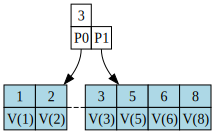

--- Visualization: EquipmentLog Table ---

#### EquipmentLog Table B+ Tree (Before Save)

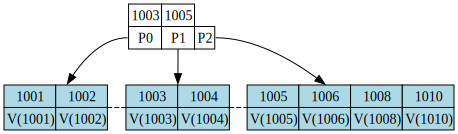


Current Equipment Records:
  Count: 6
Current Log Records:
  Count: 8

[2] Saving database state...
Database state successfully saved to 'saved_data\sports_db.pkl'.
------------------------------


In [ ]:
# --- Part 1: Create, Populate, and Save ---
print("\n[1] Initializing and Populating...")
db_manager1 = DatabaseManager()

msg, success = db_manager1.create_database('sports_management')
assert success, f"Failed to create DB: {msg}"

table_order = 5
msg, success = db_manager1.create_table('sports_management', 'Equipment', equipment_schema, order=table_order, search_key='EquipmentID')
assert success, f"Failed to create Equipment table: {msg}"

msg, success = db_manager1.create_table('sports_management', 'EquipmentLog', equipment_log_schema, order=table_order, search_key='LogID')
assert success, f"Failed to create EquipmentLog table: {msg}"

# Get table instances
eq_table, success_eq = db_manager1.get_table('sports_management', 'Equipment')
log_table, success_log = db_manager1.get_table('sports_management', 'EquipmentLog')
assert success_eq and success_log, "Failed to get table instances"

print("\nInserting sample data...")
# Sample Equipment (add a few more to make trees slightly interesting)
equipment_data = [
    {"EquipmentID": 1, "EquipmentName": "Football", "IsAvailable": True, "Condition_": "Good", "LastCheckedDate": "2024-01-10"},
    {"EquipmentID": 5, "EquipmentName": "Basket Hoop", "IsAvailable": False, "Condition_": "Fair", "LastCheckedDate": "2024-03-15"},
    {"EquipmentID": 3, "EquipmentName": "Tennis Racket", "IsAvailable": True, "Condition_": "Good", "LastCheckedDate": "2024-04-01"},
    {"EquipmentID": 8, "EquipmentName": "Volleyball Net", "IsAvailable": True, "Condition_": "Good", "LastCheckedDate": "2024-02-20"},
    {"EquipmentID": 2, "EquipmentName": "Cricket Bat", "IsAvailable": True, "Condition_": "Poor", "LastCheckedDate": "2023-11-05"},
    {"EquipmentID": 6, "EquipmentName": "Badminton Set", "IsAvailable": False, "Condition_": "Good", "LastCheckedDate": "2024-04-10"}
]
for rec in equipment_data:
    success, msg = eq_table.insert(rec)
    assert success, f"Failed insert eq {rec.get('EquipmentID')}: {msg}"

# Sample Logs (add a few more)
log_data = [
    {"LogID": 1001, "EquipmentID": 1, "IssuedTo": 501, "IssueDate": "2024-04-10 09:00:00", "ReturnDate": ""},
    {"LogID": 1005, "EquipmentID": 3, "IssuedTo": 501, "IssueDate": "2024-04-10 11:00:00", "ReturnDate": ""},
    {"LogID": 1002, "EquipmentID": 5, "IssuedTo": 502, "IssueDate": "2024-04-11 10:30:00", "ReturnDate": "2024-04-11 15:00:00"},
    {"LogID": 1004, "EquipmentID": 8, "IssuedTo": 503, "IssueDate": "2024-04-12 09:30:00", "ReturnDate": ""},
    {"LogID": 1003, "EquipmentID": 1, "IssuedTo": 503, "IssueDate": "2024-04-12 11:00:00", "ReturnDate": ""},
    {"LogID": 1006, "EquipmentID": 2, "IssuedTo": 504, "IssueDate": "2024-04-13 14:00:00", "ReturnDate": ""},
    {"LogID": 1008, "EquipmentID": 6, "IssuedTo": 502, "IssueDate": "2024-04-14 10:30:00", "ReturnDate": "2024-04-16 15:00:00"},
    {"LogID": 1010, "EquipmentID": 5, "IssuedTo": 505, "IssueDate": "2024-04-15 10:30:00", "ReturnDate": "2024-04-16 15:00:00"},

]
for rec in log_data:
    success, msg = log_table.insert(rec)
    assert success, f"Failed insert log {rec.get('LogID')}: {msg}"

print("Sample data inserted.")

# --- Visualize Before Saving ---
print("\nVisualizing table states BEFORE saving...")
if graphviz:
     display(Markdown("--- Visualization: Equipment Table ---"))
     visualize_and_display(eq_table.data, "Equipment Table B+ Tree (Before Save)") # Access B+Tree via table.data
     display(Markdown("--- Visualization: EquipmentLog Table ---"))
     visualize_and_display(log_table.data, "EquipmentLog Table B+ Tree (Before Save)")
else:
     print("Skipping visualization (graphviz not installed/found).")
     
print("\nCurrent Equipment Records:")
all_eq, _ = eq_table.get_all()
print(f"  Count: {len(all_eq)}")
print("Current Log Records:")
all_log, _ = log_table.get_all()
print(f"  Count: {len(all_log)}")

print("-" * 30)
print("\n[2] Saving database state...")
msg, success = db_manager1.save_to_disk(SAVE_FILE)
assert success, f"Failed to save: {msg}"


[3] Creating new Database Manager instance...
Database Manager initialized.
Listing databases (should be empty initially):
Available databases: []

[4] Loading database state from disk...
Database state successfully loaded from 'saved_data\sports_db.pkl'.

[5] Verifying loaded data...
Available databases: ['sports_management']
Tables in database 'sports_management': ['Equipment', 'EquipmentLog']

Visualizing table states AFTER loading...


--- Visualization: Equipment Table (Loaded) ---

#### Equipment Table B+ Tree (After Load)

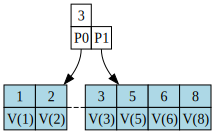

--- Visualization: EquipmentLog Table (Loaded) ---

#### EquipmentLog Table B+ Tree (After Load)

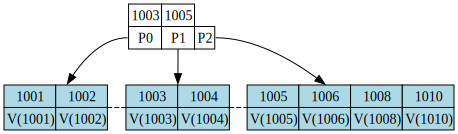


Verifying Equipment Records from loaded data:
  Found 6 records.
  Verified record ID=5.

Verifying Log Records from loaded data:
  Found 8 records.
  Verified record ID=1002.


In [81]:
# --- Part 2: Load and Verify ---
print("\n[3] Creating new Database Manager instance...")
db_manager2 = DatabaseManager()
print("Listing databases (should be empty initially):")
db_manager2.list_databases()

print("\n[4] Loading database state from disk...")
msg, success = db_manager2.load_from_disk(SAVE_FILE)
assert success, f"Failed to load: {msg}"

print("\n[5] Verifying loaded data...")
dbs, _ = db_manager2.list_databases()
assert 'sports_management' in dbs, "Loaded DB list incorrect"

tabs, _ = db_manager2.list_tables('sports_management')
assert 'Equipment' in tabs and 'EquipmentLog' in tabs, "Loaded table list incorrect"

# Get table instances from the *loaded* manager
eq_table_loaded, success_eq_load = db_manager2.get_table('sports_management', 'Equipment')
log_table_loaded, success_log_load = db_manager2.get_table('sports_management', 'EquipmentLog')
assert success_eq_load and success_log_load, "Failed to get loaded table instances"

# --- Visualize After Loading ---
print("\nVisualizing table states AFTER loading...")
if graphviz:
     display(Markdown("--- Visualization: Equipment Table (Loaded) ---"))
     visualize_and_display(eq_table_loaded.data, "Equipment Table B+ Tree (After Load)")
     display(Markdown("--- Visualization: EquipmentLog Table (Loaded) ---"))
     visualize_and_display(log_table_loaded.data, "EquipmentLog Table B+ Tree (After Load)")
else:
     print("Skipping visualization (graphviz not installed/found).")
# ----------------------------

print("\nVerifying Equipment Records from loaded data:")
all_eq_loaded, _ = eq_table_loaded.get_all()
assert len(all_eq_loaded) == len(equipment_data), "Mismatch in loaded Equipment record count"
print(f"  Found {len(all_eq_loaded)} records.")
rec, found = eq_table_loaded.get(5) # Get eq ID=5
assert found and rec == equipment_data[1], "Mismatch in loaded Equipment record ID=5" # eq_data[1] is ID 5
print("  Verified record ID=5.")

print("\nVerifying Log Records from loaded data:")
all_log_loaded, _ = log_table_loaded.get_all()
assert len(all_log_loaded) == len(log_data), "Mismatch in loaded Log record count"
print(f"  Found {len(all_log_loaded)} records.")
rec, found = log_table_loaded.get(1002) # Get log ID=1002
original_log2 = next(item for item in log_data if item["LogID"] == 1002) # Find original log2 dict
assert found and rec == original_log2, "Mismatch in loaded Log record ID=1002"
print("  Verified record ID=1002.")